<img src="2021-TPC-0232 Alexandersson.png" width="1300px"/>

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 463 ('figure.dpi       : 100        ## figure dots per inch')


In [2]:
# %load imports.py
"""
These is the standard setup for the notebooks.
"""

%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../../")

import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import OrderedDict
import copy
from sklearn.pipeline import Pipeline
from rolldecayestimators.transformers import CutTransformer, LowpassFilterDerivatorTransformer, ScaleFactorTransformer, OffsetTransformer
from rolldecayestimators.direct_estimator_cubic import EstimatorQuadraticB, EstimatorCubic
from rolldecayestimators.ikeda_estimator import IkedaQuadraticEstimator
import src.equations as equations
import rolldecayestimators.lambdas as lambdas
from rolldecayestimators.substitute_dynamic_symbols import lambdify
import rolldecayestimators.symbols as symbols
import sympy as sp

from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex

from sklearn.metrics import r2_score
import shipflowmotionshelpers.shipflowmotionshelpers as helpers
import src.visualization.visualize as visualize
import scipy
from copy import deepcopy
import joblib

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
if os.name == 'nt':
    plt.style.use('presentation.mplstyle')  # Windows
    
#plt.style.use('dark_background')
import matplotlib.font_manager

from scipy.integrate import solve_ivp
from scipy.optimize import least_squares
from rolldecayestimators import fit_on_amplitudes
from reports import mdl_results
import rolldecayestimators.ikeda as ikeda_classes
from pyscores2.indata import Indata
from pyscores2.output import OutputFile
import joblib
import src.visualization.visualize as visualize
from rolldecayestimators import equations_ikeda_naked
from sympy import latex
from rolldecayestimators import logarithmic_decrement
from copy import deepcopy
import src.helpers
from src.notebook_to_latex import Equation, equation_dict

## Examples:
from reports import mdl_results
import reports.examples as examples
import reports.examples.ikeda_V_phi_a
import reports.examples.analytical_numerical
import reports.examples.eddy_sigma
import reports.examples.ikeda_section_table
import reports.examples.decision_tree
import reports.examples.KVLCC2_section_table
import reports.examples.logaritimic_decrement
import reports.examples.mdl
from reports.examples.mdl import plot_amplitudes
import reports.examples.ikeda
import reports.examples.hybrid_0
import reports.examples.hybrid_speed
import reports.examples.FNPF
import reports.examples.KVLCC2
import reports.examples.differentiation_vs_integration

In [4]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf','png')
from IPython.display import HTML, Markdown, Image
from src.df_to_latex import LateXTable

# Abstract
Getting the best possible accuracy with the lowest possible computational cost is an important
factor in the early design stage of ships. Potential flow-based analysis presents such a solution for seakeeping analyses. The accuracy of roll motion in potential flow is however not so good, due to the large influence from vicsous roll damping, which is missing in these calculations.
This paper proposes a hybrid method, as a solution to this problem, where the viscous roll damping from Ikeda's semi-empirical method is injected into an existing 3D unsteady fully nonlinear potential flow (FNPF) method.
The hybrid method is investigated using roll decay tests with the KVLCC2 test case. This investigation shows that the accuracy of simulated roll motions is significantly improved and also shows good agreement with the corresponding roll decay model tests.

# Introduction
Inviscid potential flow calculations can be used to solve seakeeping problems at very low computational costs. These methods offer far cheaper alternatives than doing for instance model tests or URANS calculations. Potential flow calculations can therefore be used extensively during the early design stage of ships. The pitch and heave motions can be predicted with good accuracy, even with the older linear strip theory methods <cite data-cite="7505983/FB64RGPF"></cite>. The roll motions will however not be very realistic in potential flow, due to high influenced from viscous roll damping. This is very unfortunate as the roll motions is indeed a very important response. The impact of roll motions can be seen from the APL China casualty in 1998, where a post-Panamax C11 class container ship lost almost a third of its containers <cite data-cite="7505983/WPADAQB3"></cite>. Another example is the container ship Svendborg Maersk, were 500 containers were lost overboard and 250 containers were damaged as a result of heavy roll motions during a passage from English Channel to Gibraltar <cite data-cite="7505983/T78CMTDR"></cite>.

A lot of experimental research was conducted during the 1970s and 80s to separate the invicid and viscous roll damping. Semi-empirical formulas were developed to estimate the viscous parts, to be used together with the potential flow methods <cite data-cite="7505983/937PN5DT"></cite>. 
The older linear methods can today be replaced by more advanced nonlinear potential flow methods. These newer methods still need some injection of semi-empirical viscous damping to give a fair representation of the roll motions. But is the separation of damping components still valid, considering that these older semi-empirical methods were developed in close connection to linear strip theory? <cite data-cite="7505983/UGK6YEVD"></cite> have shown that the separation of viscous and invicid damping is still valid for a panel method and Ikeda's method to predict the roll motion for the mentioned APL China vessel. <cite data-cite="7505983/24TNAV5Z"></cite> have investigated an even more advanced method, using a fully nonlinear potential flow method (FNPF) <cite data-cite="7505983/P4XDUMMQ"></cite> combined with Watanabe and Inoue method (W-I) <cite data-cite="7505983/ARMIRMVY"></cite> to predict the viscous damping for the DTC test case <cite data-cite="7505983/BYNJ8CFG"></cite>. This FNPF method is used also in the present paper, but instead of W-I method, Ikeda's method is used instead. Ikeda's method is believed to be a good method for the purpose, based on results from a previous comparisons of a large number of model scale roll decay tests <cite data-cite="7505983/QMGQ76Q9"></cite>.

The implementation of the proposed hybrid method is introduced in the next section where the underlying Ikeda's method and FNPF method are both presented. The implementation of Ikeda's method is also closely examined and an alternative way to calculate eddy damping is proposed. In the validation study of the hybrid method, roll decay tests from model tests are compared with simulations for the KVLCC2 test case. In the roll decay tests, both decay and frequency can be observed, without the presence of external forces from wind and waves. This gives a good indication of the ship's roll damping and inertia. A more thorough description of the roll decay test is given in the Roll decay test section of this paper.

#  Proposed hybrid method
A hybrid method is proposed in this paper, where wave damping $B_W$ (including the speed dependent wave damping)  obtained implicitly with FNPF is used together with the viscous damping contributions from Ikeda's method. The viscous damping is added to the FNPF simulations by injecting the viscous parts of the linear and quadratic damping coefficients (obtained with Ikeda's method) to the equation of motion. Ikeda's method divides roll damping into five damping components so that the total damping can be calculated as <cite data-cite="7505983/937PN5DT"></cite>,
\begin{equation}
B = B_F + B_E + B_L + B_W + B_{BK}
\end{equation}
Where $B_F$ is the skin friction component, $B_E$ is the eddy generation component, $B_L$ is hull lift component, $B_W$ is roll wave generation component and $B_{BK}$  is the bilge keel component. Ikeda's method propose semi-empirical formulas for the viscous damping components: $B_F$, $B_E$, $B_{BK}$ and $B_L$ so that viscous damping can be obtained from, 
<a id='eq_viscous_damping'>
\begin{equation}
\label{eq:viscous_damping}
B_{visc} = B_F + B_E + B_L
\end{equation}

In order to reduce the number of uncertain parameters, the bilge keel damping $B_{BK}$ has been exluded in Eq.[(above)](#eq_viscous_damping), thereby assuming that the ship does not have any bilge keels. 

The skin friction damping $B_F$ is calculated using <cite data-cite="7505983/CKCMI3N9"></cite> which is implemented according to the description in <cite data-cite="7505983/UGK6YEVD"></cite>. The scale effects of roll damping are considered to mainly be associated with the skin friction component $B_F$ <cite data-cite="7505983/FB64RGPF"></cite>. This component constitutes a very small part of the total damping for the full scale ship but a substantial part for the model scale ship used in this study. This is therefore the only component in Ikedas method that needs to be recalculated when the scale changes.  

The hull lift damping $B_L$ is calculated according to <cite data-cite="7505983/937PN5DT"></cite> and implemented as described in <cite data-cite="7505983/UYUAYY7E"></cite> where the calculations have been improved with a linear interpolation of the values for $\kappa$ from <cite data-cite="7505983/937PN5DT"></cite>.

Ikeda's method calculates the roll damping at a certain roll angle frequency $\omega$ and roll angle amplitude $\phi_a$. A schematic graph of how the parameters vary with speed and roll angle amplitude $\phi_a$ is shown in Fig.[(below)](#fig_ikeda_generic). In this figure, roll amplitude is first varied at zero speed (left). The speed is then varied at constant roll angle amplitude of 10 degrees (middle). The amplitude is then gradually reduced at the highest speed down to zero again (right). 

Assumming that the trends are correct in Ikeda's method it can be noted from the amplitude variations at zero speed (left):
* $B_W$ does not change with amplitude, implying that they only contribute to the linear part ($B_1$) of the damping. (The $B_W$ was calculated with strip theory here)
* $B_F$ has a small amplitude dependency but the linear part is dominating.
* $B_E$ has a large amplitude depandancy and only contributes to the quadratic damping ($B_2$)<cite data-cite="7505983/4AFVVGNT"></cite>.

Looking at the speed variation (middle):
* At low speed $B_F$ and $B_E$ are the dominating components. (Note that this ship does not have bilge keels, as that would otherwise also be a large component).
* At high speed the $B_E$ has almost disappeared and is replaced by the $B_L$ which is now the dominating component.
* $B_F$ has a large contribution for all speeds (at model scale).

Looking at the roll amplitude variation (right):
* (Please note that this horizontal axis is reversed in this graph)
* $B_L$ does not change with amplitude, implying that they only contribute to the linear part ($B_1$) of the damping.
* $B_F$ has a small amplitude dependency but the linear part is dominating.

<a id='fig_ikeda_generic'></a>

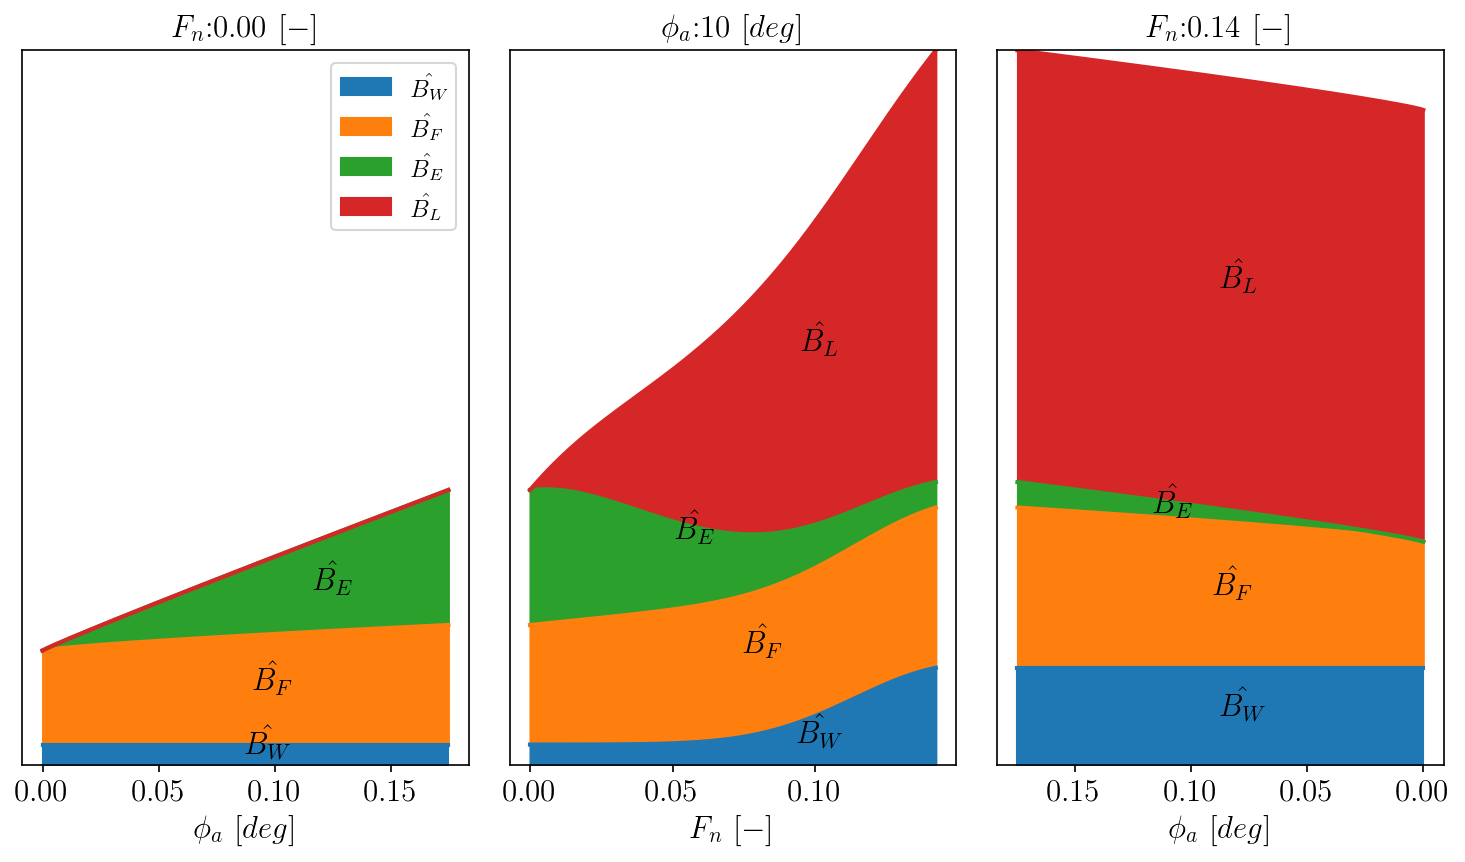

In [49]:
fig = examples.ikeda_V_phi_a.show()

When the damping predicted with Ikeda's method was compared with corresponding
model tests (see section [(here)](#se_validation)), it was found that the results were in poor agreement for the
zero speed case (see Fig.[(see)](#fig_ikeda) (left)) but quite good results at speed. This was pointing
towards the eddy damping being incorrect in the current implementation
of Ikeda's method. A thorough investigation of the eddy damping
prediction was therefore conducted which is described in the next
section.

## Eddy damping
At zero speed, the eddy damping $B_{E0}$ represents a nonlinear force caused by the two-dimensional separation near the bilge keel. The eddy damping is also nonlinear at speed where it represents the nonlinear part of the hydrodynamic lift damping ($B_L$ represents the linear part).
The speed dependency of the eddy damping is calculated using the following semi-empirical formula <cite data-cite="7505983/937PN5DT"></cite>: 

In [6]:
Equation(equations_ikeda_naked.eq_eddy_speed, label='eq:eddy_speed')

<src.notebook_to_latex.Equation object>

Where $K$ is the reduced frequency:

In [7]:
Equation(equations_ikeda_naked.eq_K, label='eq:K')

<src.notebook_to_latex.Equation object>

For the zero speed case, Fig.[(see)](#fig_eddy_sigma) is an illustration of how the eddy damping changes with bilge radius as predicted with the current implementation of the method. It seems that the damping approaches zero very fast as the bilge radius increases. Having just a small rounding of the bilge, compared to a square section, will thereby have a great impact on the eddy roll damping.  

<a id='fig_eddy_sigma'></a>

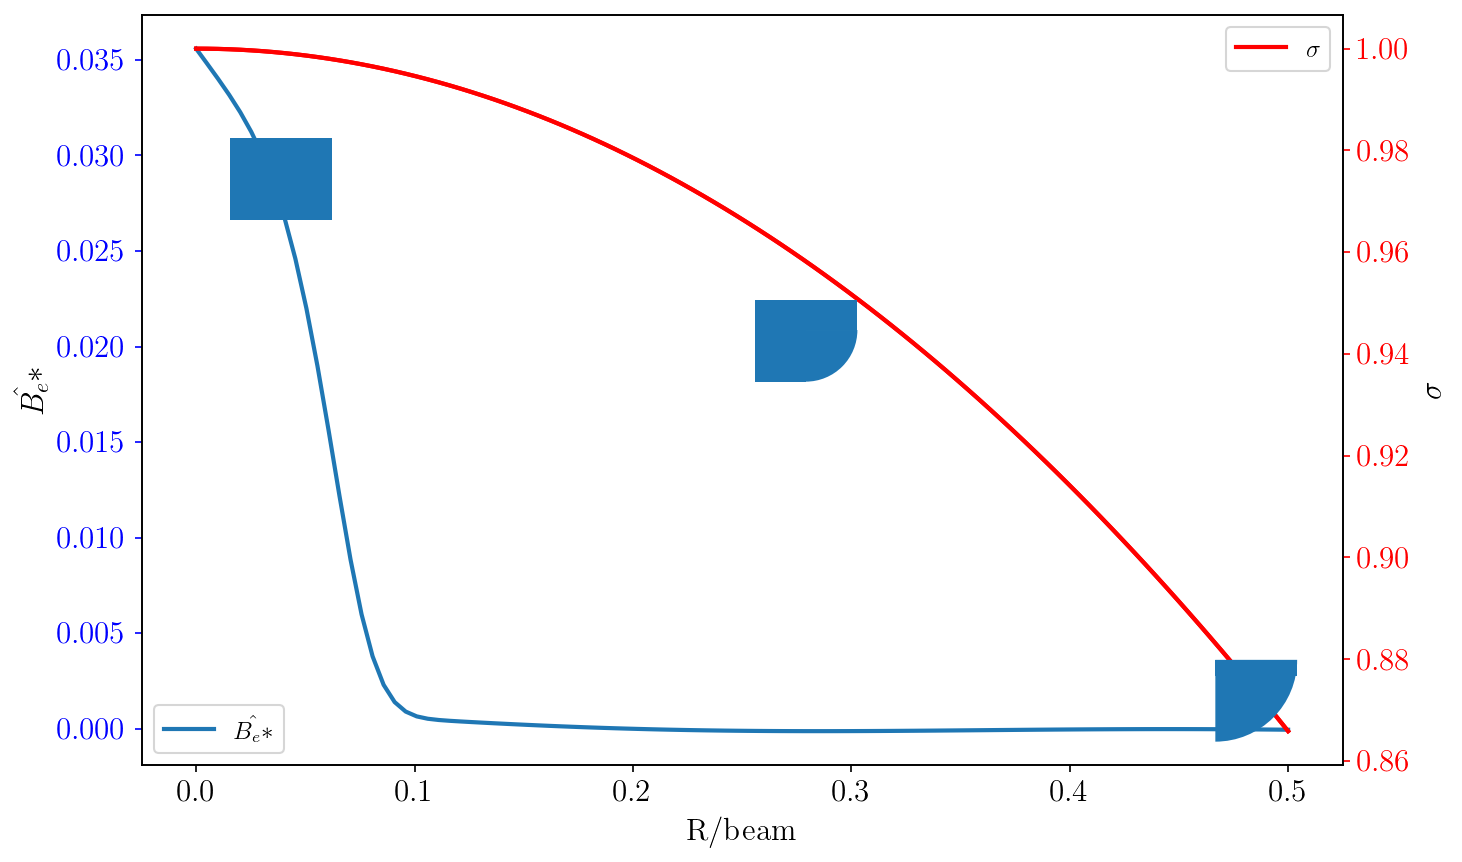

In [8]:
examples.eddy_sigma.show()

Even though this tree is very simple it has very good accuracy in reproducing the results from Ikedas experiments ($r^2=0.996$) compared to ($r^2=0.762$) when using Ikeda's method. Fig.[(below)](#fig_ikeda_sections) shows $C_r$ from the experiments and corresponding predictions with Ikeda's method and the decision tree. The capital letters refer to cylinder sections from the experiments <cite data-cite="7505983/4AFVVGNT"></cite>. 

<a id='fig_ikeda_sections'></a>

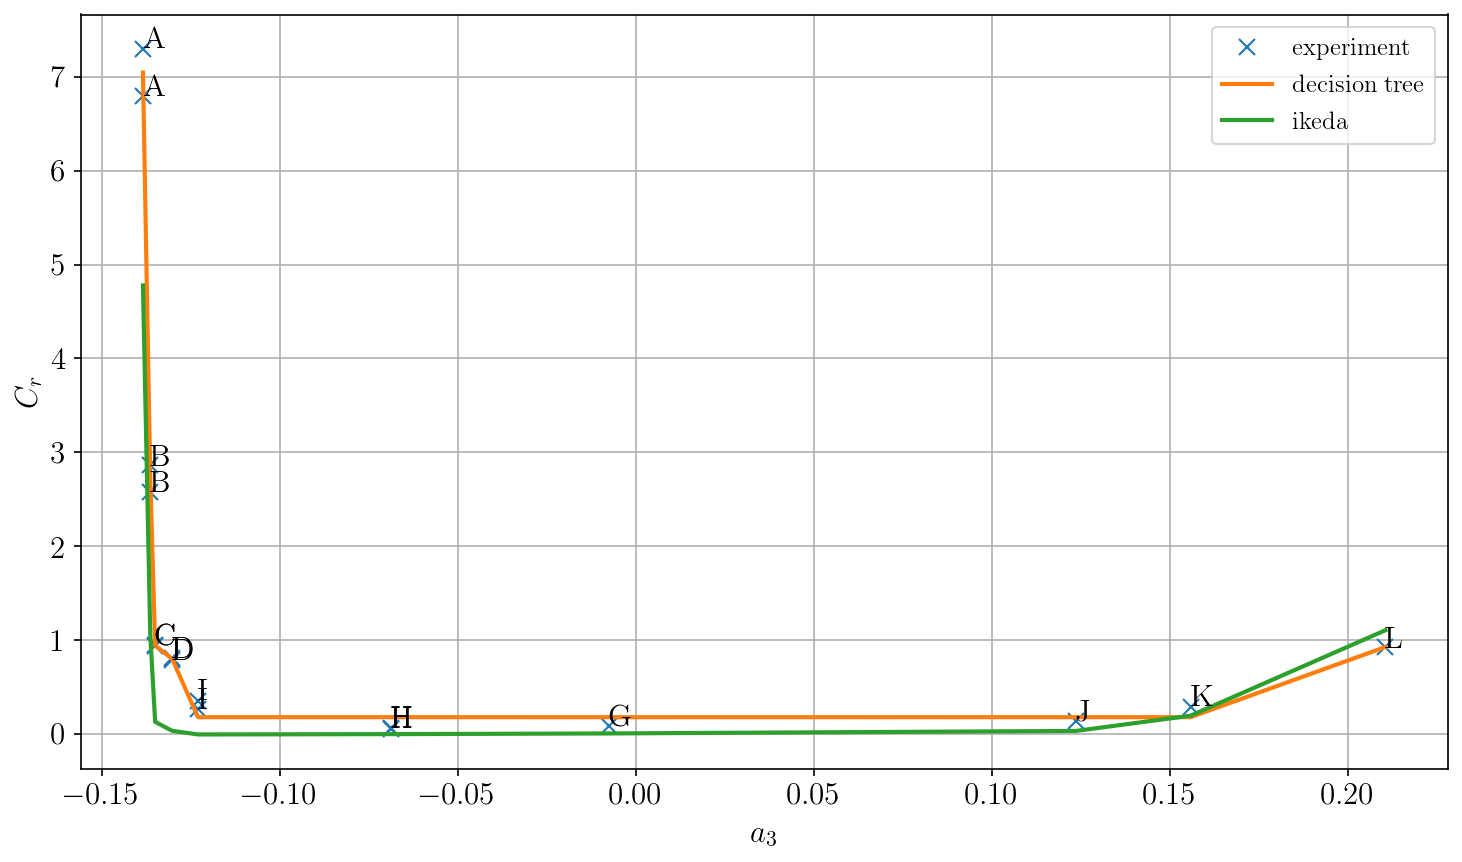

In [9]:
examples.decision_tree.show_regression()


## FNPF method
\label{fnpf-method}
The wave damping was obtained using parameter an identification technique, as described in section: [PIT method](#se_pit), on roll decay simulation using the fully nonlinear potential flow method. This method is characterized by the application of the complete dynamic and kinematic free surface boundary conditions on the instantaneous free surface as well as the body-exact approach where the instantaneous wetted body surface is considered in the boundary value problem for the velocity potential, i.e. no linearizations are made to the governing equations of the potential flow problem.

The method used in this study employs a boundary element method (BEM) <cite data-cite="7505983/FD4N3DW2"></cite> to solve the boundary value problem for the velocity potential.

The free surface boundary conditions and the motions of the floating body introduce time dependency to the boundary value problem. The BEM is coupled with the mixed Eulerian-Lagrangian method (MEL) <cite data-cite="7505983/ZKB494GT"></cite> which is used for the evolution of free surface. A fourth-order Adams-Bashforth-Moulton time integral scheme is then used to evolve free surface and the rigid-body body motions in time.

The benefit with the FNPF method is the lack of linearizations to the free surface potential flow where all interactions between the undisturbed incident flow and surface piercing body is captured implicitly in the total velocity potential, including inviscid (wave) damping due to radiation and diffraction. The downside is the larger computational cost compared to many other potential flow based methods due to the fact that a boundary value problem for the velocity potential must be solved at least once every time step, depending on the specifics of the time integral scheme. 
A factor of approximately 1000 between wall-clock time and simulated time on a computer with 32 cores (Intel(R) Xeon(R) CPU E5-4627 v2 @ 3.30GHz) can be expected. This is typically less computationally demanding than for example URANS methods, making FNPF methods attractive choices for seakeeping problems. 

# Roll decay test

A common way to determine the roll damping of a ship is to
conduct a roll decay test using: model tests, CFD simulations or in some rare cases at full scale tests. The initial heel angle during this test gives
the ship potential energy that subsequently is shifting to kinetic energy as the ship
starts to oscillate during the initial phase of the roll decay test. The
energy is transferred between kinetic and potential energy during the
oscillations. The ship loses energy over time due to the damping as shown in Fig.[(below)](#fig_energy):

<a id='fig_energy'></a>

In [10]:
Equation(equations.roll_decay_equation_general_himeno, label='eq:roll_decay_equation_general_himeno')

<src.notebook_to_latex.Equation object>

Where $B_{44}(\dot{\phi})$ and $C_{44}(\phi)$ are the damping and stiffness models. A quadratic model can be obtained by using quadratic damping <cite data-cite="7505983/FB64RGPF"></cite>:

In [11]:
Equation(equations.b44_quadratic_equation, label='eq:b44_quadratic_equation')

<src.notebook_to_latex.Equation object>

And a higher order stiffness model <cite data-cite="7505983/KL7A3RIV"></cite>:

In [12]:
Equation(equations.restoring_equation_cubic, label='eq:restoring_equation_cubic')

<src.notebook_to_latex.Equation object>

The total equation is then written:

In [13]:
Equation(equations.roll_decay_equation_quadratic_, label='eq:roll_decay_equation_quadratic', max_length=200)

<src.notebook_to_latex.Equation object>

In [14]:

eq_phi1d = sp.Eq(symbols.phi_dot_dot,
      sp.solve(equations.roll_decay_equation_quadratic_A,symbols.phi_dot_dot)[0])

accelaration_lambda = lambdify(sp.solve(eq_phi1d,symbols.phi_dot_dot)[0])

Equation(eq_phi1d, label='eq:eq_phi1d', max_length=200)

<src.notebook_to_latex.Equation object>

<a id='eq_b_1_zeta_eq'></a>

In [15]:
Equation(equations.B_1_zeta_eq, label='eq:b_1_zeta_eq')

<src.notebook_to_latex.Equation object>

and the natural frequency can be obtained from:

In [16]:
omega0_eq = equations.omega0_equation.subs(symbols.C,symbols.C_1)
omega0_lambda = lambdify(sp.solve(omega0_eq, symbols.omega0)[0])
Equation(omega0_eq, label='eq:omega0_eq')

<src.notebook_to_latex.Equation object>

The analytical and numerical solutions are very similar according to the example: $A_{44} = 1.0$, $B_1 = 0.3$, $C_1 = 5.0$ shown in Fig.[(see)](#fig_analytical_numerical). The numerical integration was done with Explicit Runge-Kutta method of order 5(4) with 0.01 s time step.

<a id='fig_analytical_numerical'></a>

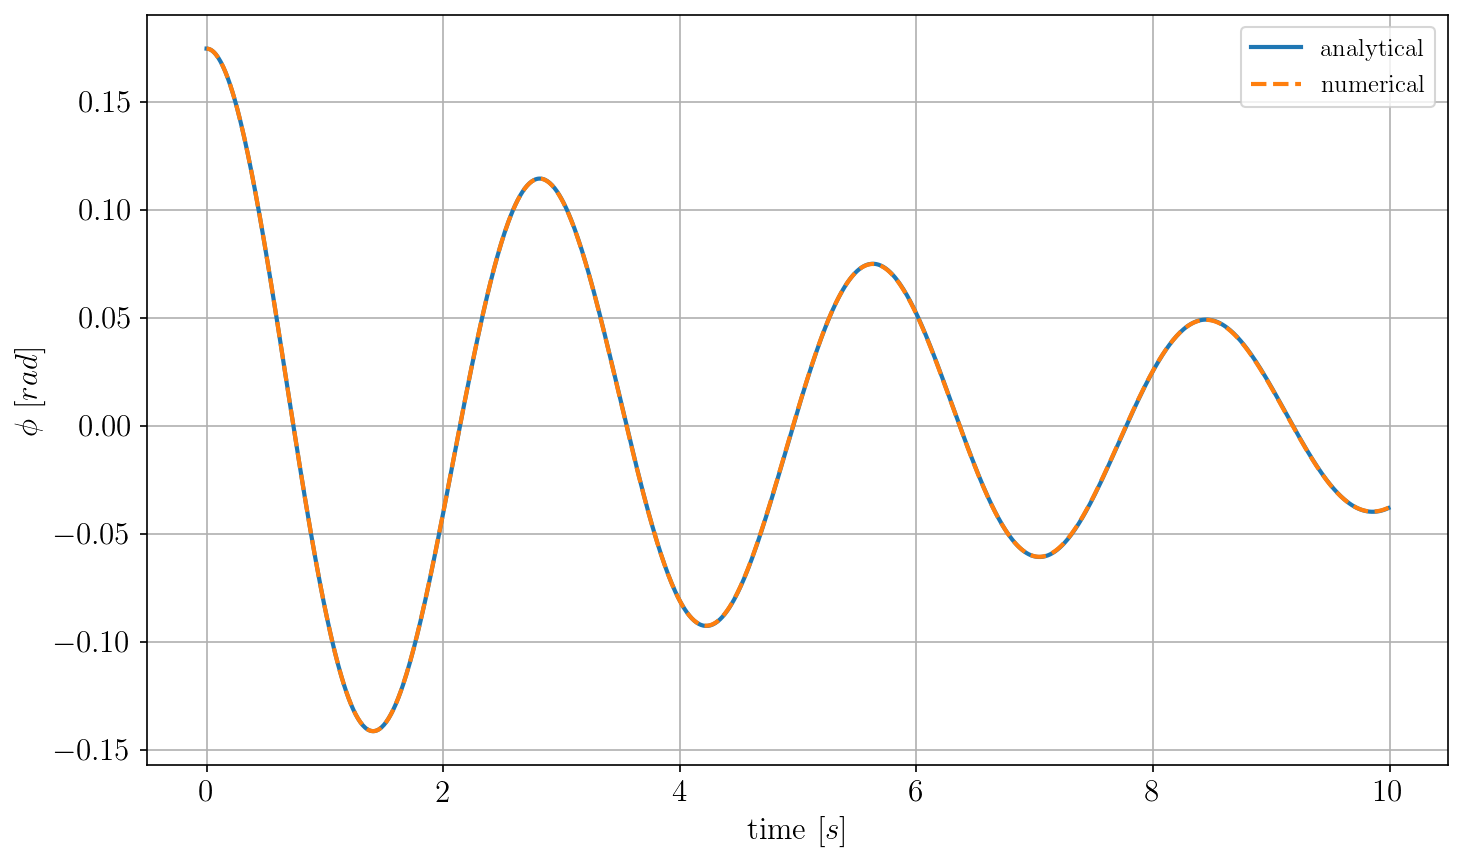

In [17]:
examples.analytical_numerical.show(omega0_lambda=omega0_lambda, 
                                   accelaration_lambda=accelaration_lambda, dt=0.01);

The parameters of Eq.[(here)](#eq_eq_phi1d) can be identified using least square fit if the time signals $\phi(t)$, $\dot{\phi}(t)$ and $\ddot{\phi}(t)$ are all known. This is the case for the results from the FNPF simulations but not from the model tests, where only the roll signal $\phi(t)$ is known. The other time derivatives can be estimated using numerical differentiation of a low-pass filtered roll signal or Kalman filtered roll signal. The filtering will however introduce some errors in itself. 
As an alternative of using this "Differentiation approach", an "Integration approach" similar to what was used by <cite data-cite="7505983/FJHQJJUH"></cite> and <cite data-cite="7505983/24TNAV5Z"></cite> can also be used. The differential equation is solved numerically for estimated parameter values determined with optimization.
Gausian noise with 0.2 degrees standard deviation was added to the simulated roll signal in Fig.[(above)](#fig_analytical_numerical) to mimic measurement noise. Fig.[(here)](#fig_diff_vs_int) shows a comparison between these two approaches for a variation of the low pass filter cutoff frequency. A very high cutoff frequency means that most frequencies pass through the filter undisturbed. It can be seen that the estimation of damping coefficient $B_{1A}$ with "Differentiation approach" depends very much on the filter setting. The "Integration approach" was therefore selected for this study, being the more accurate and robust solution.
One problem is however that the optimization needs a reasonable first guess of the parameters to converge. The Differentiation approach was therefore used as a pre-step to obtain a very good first guess of the parameters that can be passed on to the Integration approach. This has been used for both signals from FNPF and model tests, where in the latter case numerical differentiation is used. 

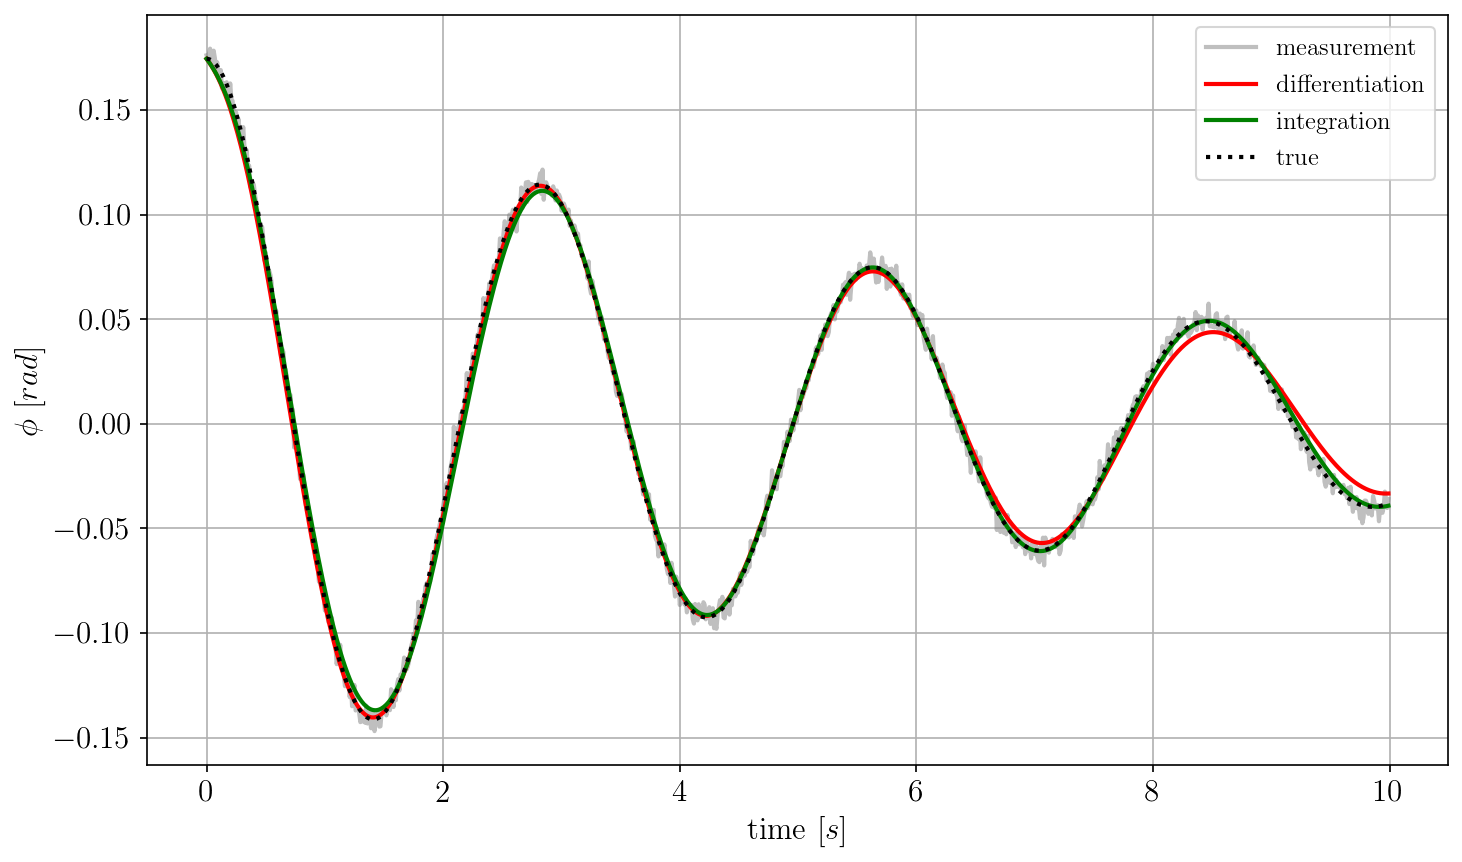

In [18]:
df_measure,df_true = examples.differentiation_vs_integration.show(omega0_lambda=omega0_lambda, 
                                   accelaration_lambda=accelaration_lambda, dt=0.01)

<a id='fig_diff_vs_int'></a>

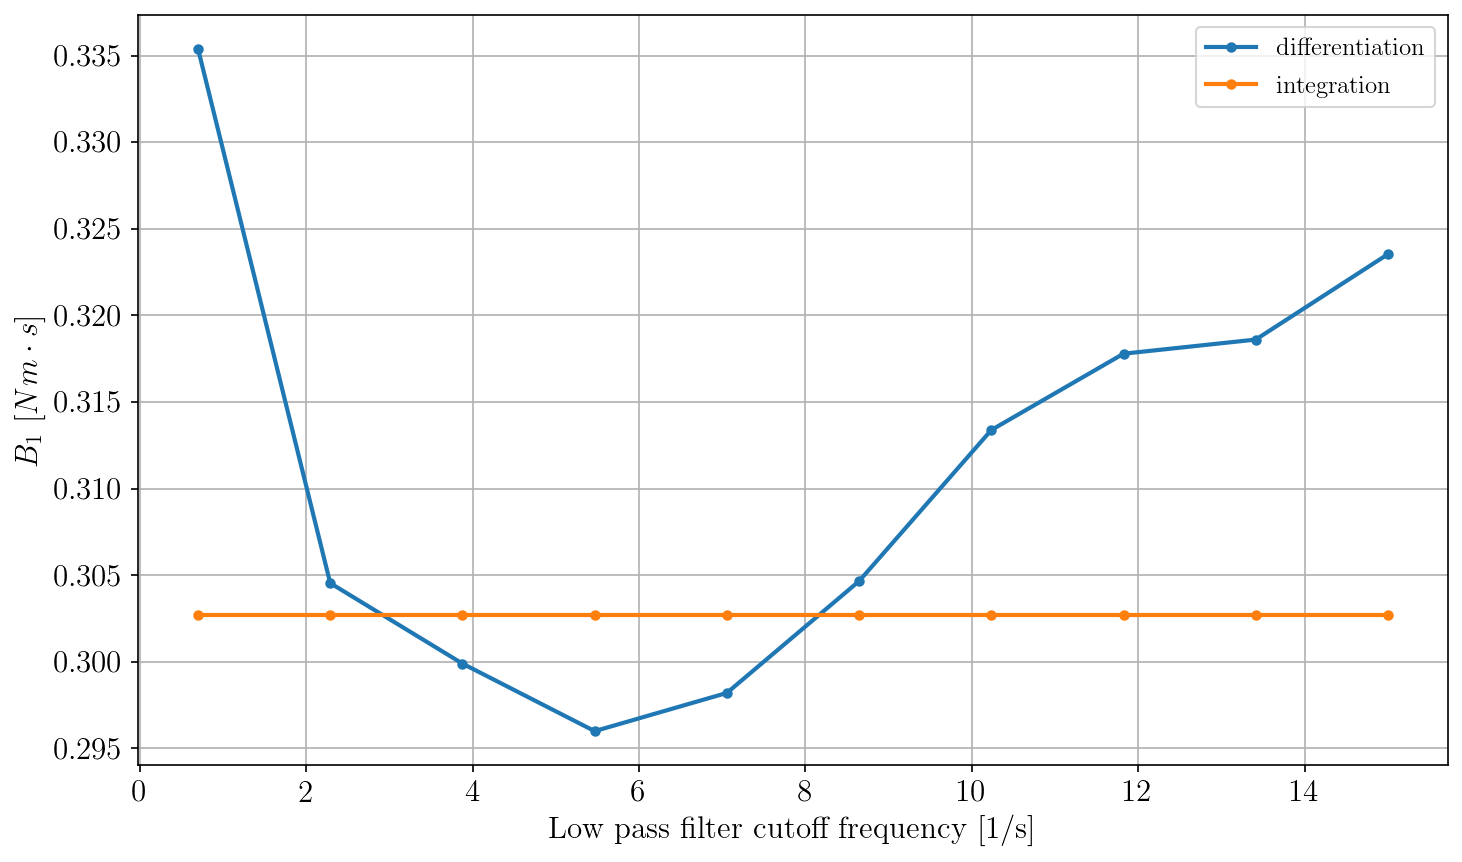

In [19]:
examples.differentiation_vs_integration.vary_cutoff(df_measure=df_measure, df_true=df_true)

## Time and frequency domain
<a id='se_time_and_frequency'></a>
\label{se:time_and_frequency}
Ikeda's method is defined in the frequency domain. The damping is expressed as function of roll angle amplitude $\phi_a$ and roll angle frequency $\omega$. The roll decay tests are however in the time domain, where the damping instead needs to be expressed as function of the roll velocity $\dot{\phi}$. This can be obtained using the equivalent linear damping $B_e$ (not to confuse with eddy damping $B_E$).
The most general way to determine $B_e$ is to assume that the energy loss due to damping during a half cycle of roll is the same when nonlinear and linear dampings are used <cite data-cite="7505983/RYUBZITQ"></cite>. The $B_e$ can be calculated as a Fourier series expansion of the damping model, which in the case of a quadratic model yields as <cite data-cite="7505983/FB64RGPF"></cite>: 

In [20]:
Equation(equations.B_e_equation, label='eq:B_e_equation')

<src.notebook_to_latex.Equation object>

$B_1$ and $B_2$ can be calculated with this equation by assuming that the damping for a variation of roll amplitudes corresponds to the equivalent linear damping for the same amplitudes <cite data-cite="7505983/FB64RGPF"></cite>. This way $B_1$ and $B_2$ from the quadratic model (Eq.[(here)](#eq_eq_phi1d)) fitted on roll decay tests can be compared with corresponding values from Ikeda's method. The logaritmic decrement method <cite data-cite="7505983/BYNJ8CFG"></cite> can be used to measure the frequency domain quantities directly from roll decay tests (without fitting a model first). In this method the peaks in the signal are first measured as shown in Fig.[(below)](#fig_peaks).

<a id='fig_peaks'></a>

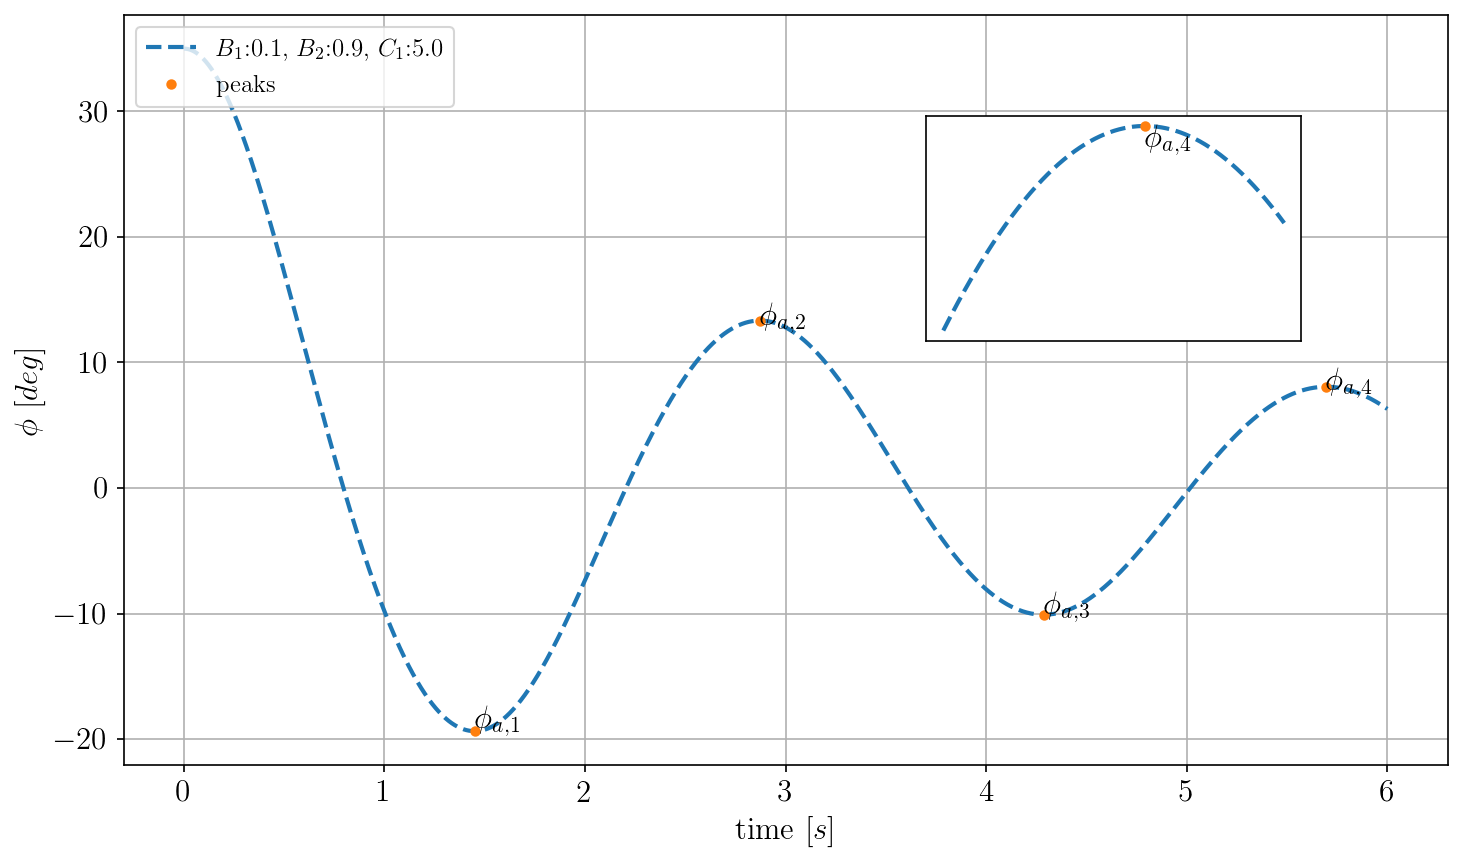

In [21]:
examples.logaritimic_decrement.show_figure_1()

The decrement $\Delta_n$ is calculated as the ratio between every other peak, so that negative and positive roll peaks are separated. This decrement can be calulated for each peak:

In [22]:
Equation(r'\Delta_n = \frac{\phi_{a,n}}{\phi_{a,n+2}}', label='decrement')

<src.notebook_to_latex.Equation object>

The nondimensional $\zeta$ damping coefficient for each peak can be calculated from the logaritimic decrement <cite data-cite="7505983/BYNJ8CFG"></cite>:

In [23]:
Equation(r'\zeta_n = \frac{\delta_n}{2\pi}=\frac{ln(\Delta_n)}{2\pi}', label='zeta_n')

<src.notebook_to_latex.Equation object>

The dimensional damping $B_n$ $[Nm \cdot s]$ for each peak can be calculated using Eq.[(here)](#eq_b_1_zeta_eq).

The roll amplitude is calculated as the mean value of the three peaks in the time window where $B_n$ is calculated:

In [24]:
Equation(r'\phi_a = (\phi_{a,n} + \phi_{a,n+1} + \phi_{a,n+2})/3', label='phi_a')

<src.notebook_to_latex.Equation object>

# Case studies for validation
<a id='se_validation'></a>
\label{se:validation}

The hybrid method in this paper is investigated using the well known KVLCC2 test case. This ship was selected partly because it is a well known test case and also because it does not have any bilge keels. Results from roll decay simulations made with the hybrid method will be compared to corresponding model test data from the SSPA Maritime Dynamics Laboratory. From these model tests, only the total damping can be observed. Reducing the number of components by having no bilge keels will therefore give more insight into the remaining components. The main dimensions of the KVLCC2 scale model are shown in Tab.[(below)](#tab_kvlcc2_model_data) and the body plan of the full scale ship at the tested draught is shown in Fig.[(below)](#fig_body_plan). A section table can also be found in the Appendix Tab.[(here)](#tab_kvlcc2_section_table).

<a id='tab_kvlcc2_model_data'></a>

In [25]:
examples.KVLCC2.show()

[Index(['$L_{pp}$', '$b$', '$v_{cg}$', '$k_{xx}$', '$S$', '$Disp$', '$rho$',
        '$T$'],
       dtype='object'),
 array(['$[m]$', '$[m]$', '$[m]$', '$[m]$', '$[m^2]$', '$[m^3]$',
        '$\\left[\\frac{kg}{m^3}\\right]$', '$[m]$'], dtype=object),
 array([4.706, 0.853, 0.274, 0.341, 5.981, 0.993, 1000.0, 0.306],
       dtype=object)]

<a id='fig_body_plan'></a>

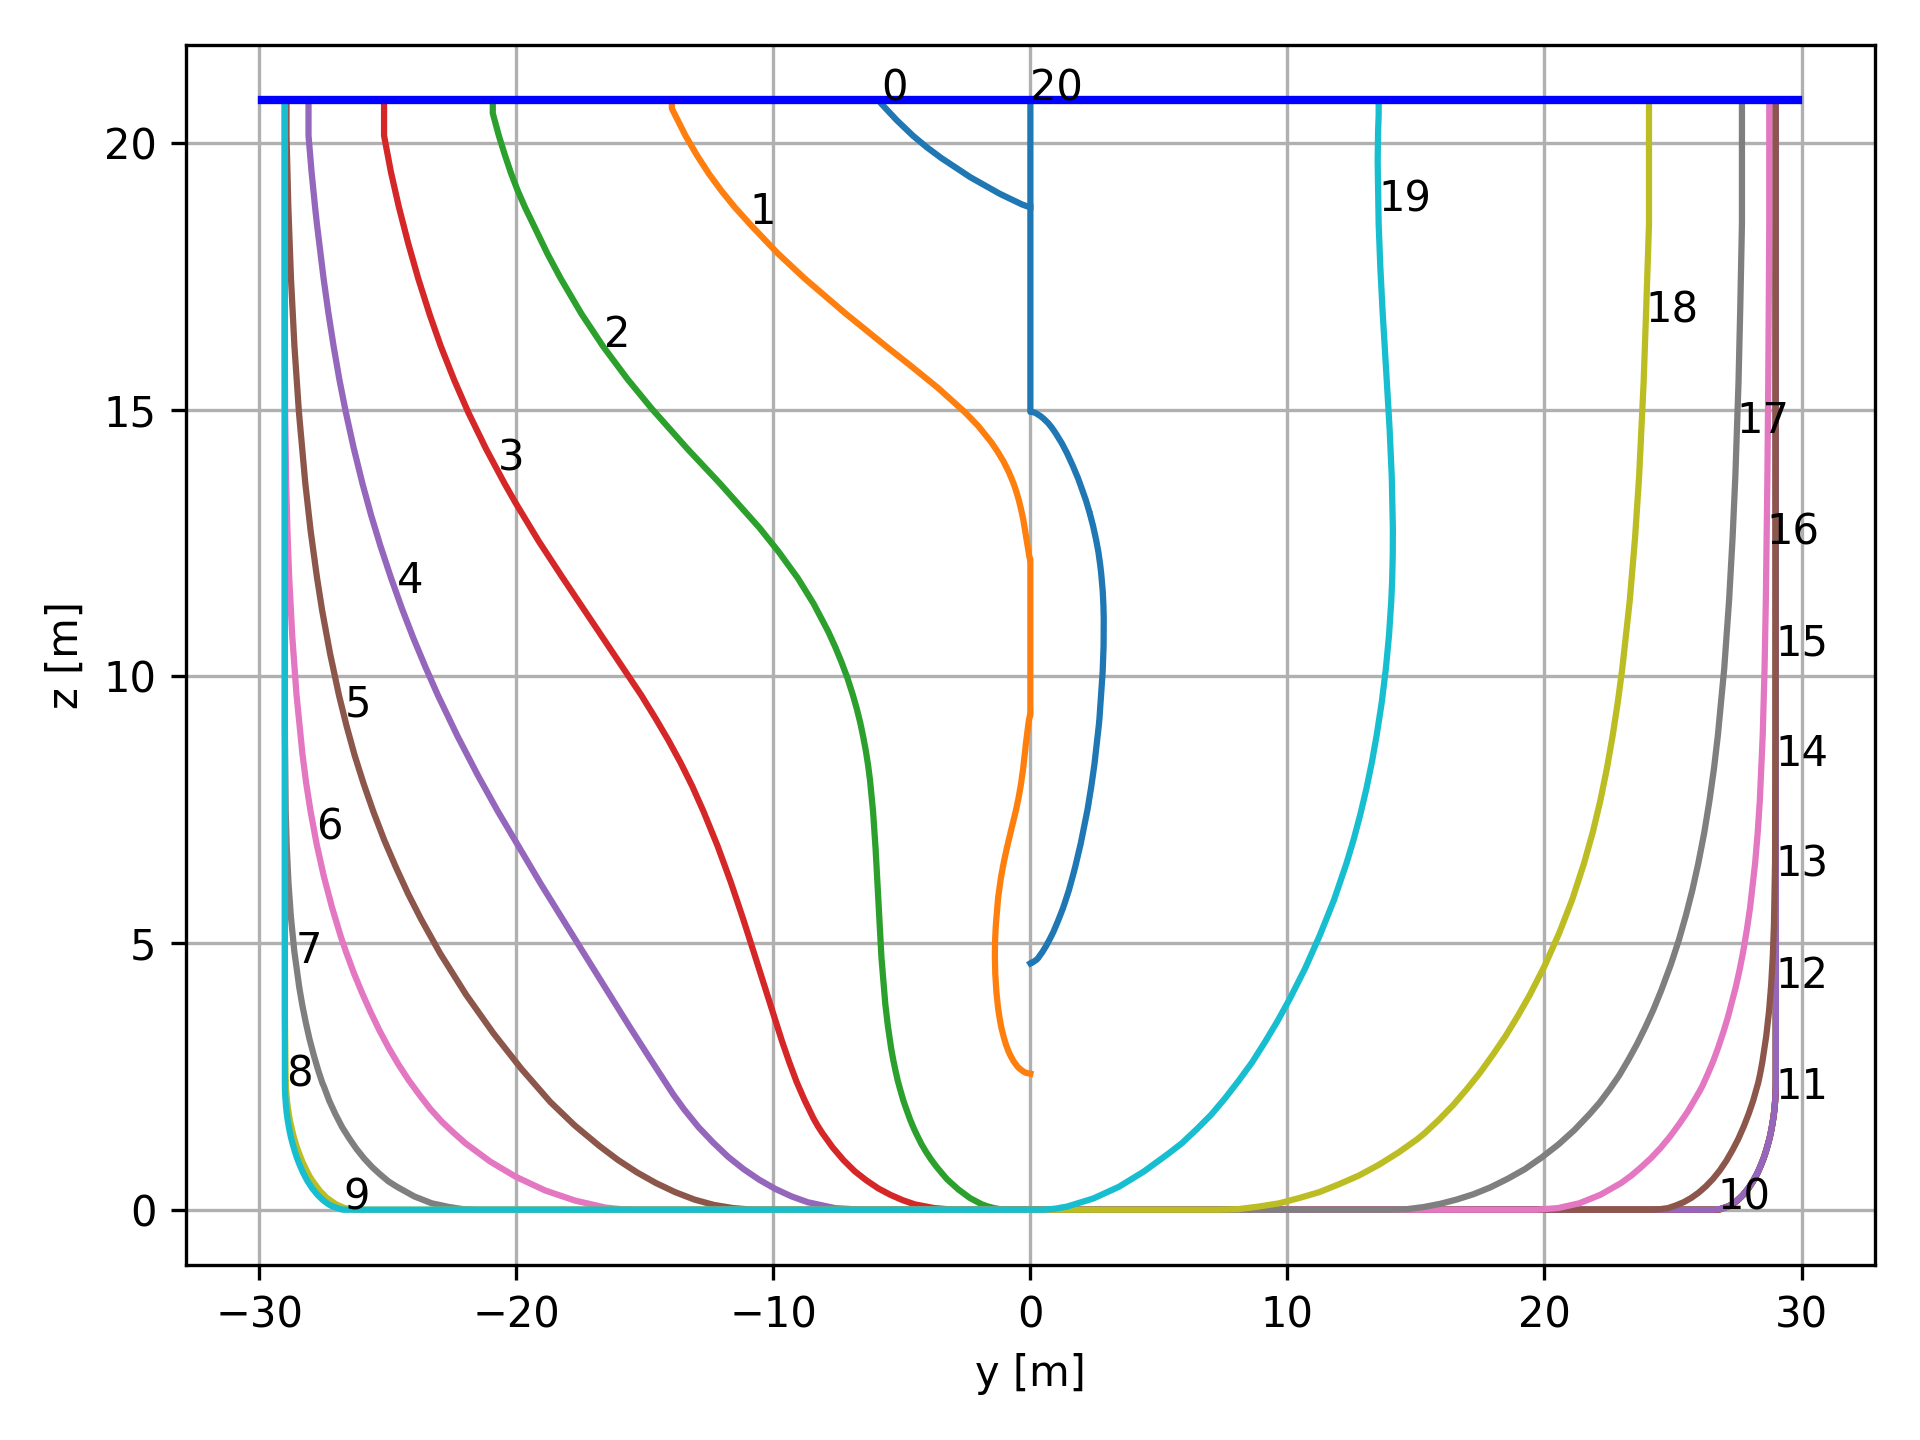

In [26]:
Image('../figures/KVLCC2_body_plan.png')

# Results

In [27]:
models_mdl = examples.mdl.get_models()
df_results_mdl = examples.mdl.gather_results(models_mdl)

## Roll decay model tests
### Test at 0 knots
Two roll decay model tests were conducted at zero speed referred to as Run 1 and 2 <cite data-cite="7505983/5DP3HN8F"></cite>. [(rolldecay)](../../notebooks/01.2_select_suitable_MDL_test_KLVCC2.ipynb#rolldecay) These tests where analyzed by fitting a quadratic model [(cubic_model)](../../notebooks/01.2_select_suitable_MDL_test_KLVCC2.ipynb#cubic_model) to the model test data. The two models were very similar in terms of roll damping and stiffness (see Fig.[here](#fig_mdl)), suggesting good repeatability in both the model tests and in the parameter identification technique (PIT) used. It can be seen that the dampings, from each individual oscillation obtained with the logarithmic decrement method, are very scattered. This scatter does not seem to influence the two models for the 0 speed case, which are very similar.  

### Test at 15.5 knots
One roll decay model tests, referred to as Run 3 <cite data-cite="7505983/5DP3HN8F"></cite>, was conducted at a ship speed corresponding to 15.5 knots full scale ship speed (see Fig.[here](#fig_mdl)). The ship got a small yaw rate [(yaw rate)](../../notebooks/01.3_select_suitable_MDL_test_KLVCC2_speed.ipynb#yawrate) at the end of test, giving a small steady roll angle due to the centrifugal force. Since this effect is not included in the mathematical model used, the steady roll angle was instead removed by removing the linear trend in the roll angle signal. 

In [28]:
amplitudes = examples.mdl.analyze_amplitudes(models=models_mdl)

<a id='fig_mdl'></a>

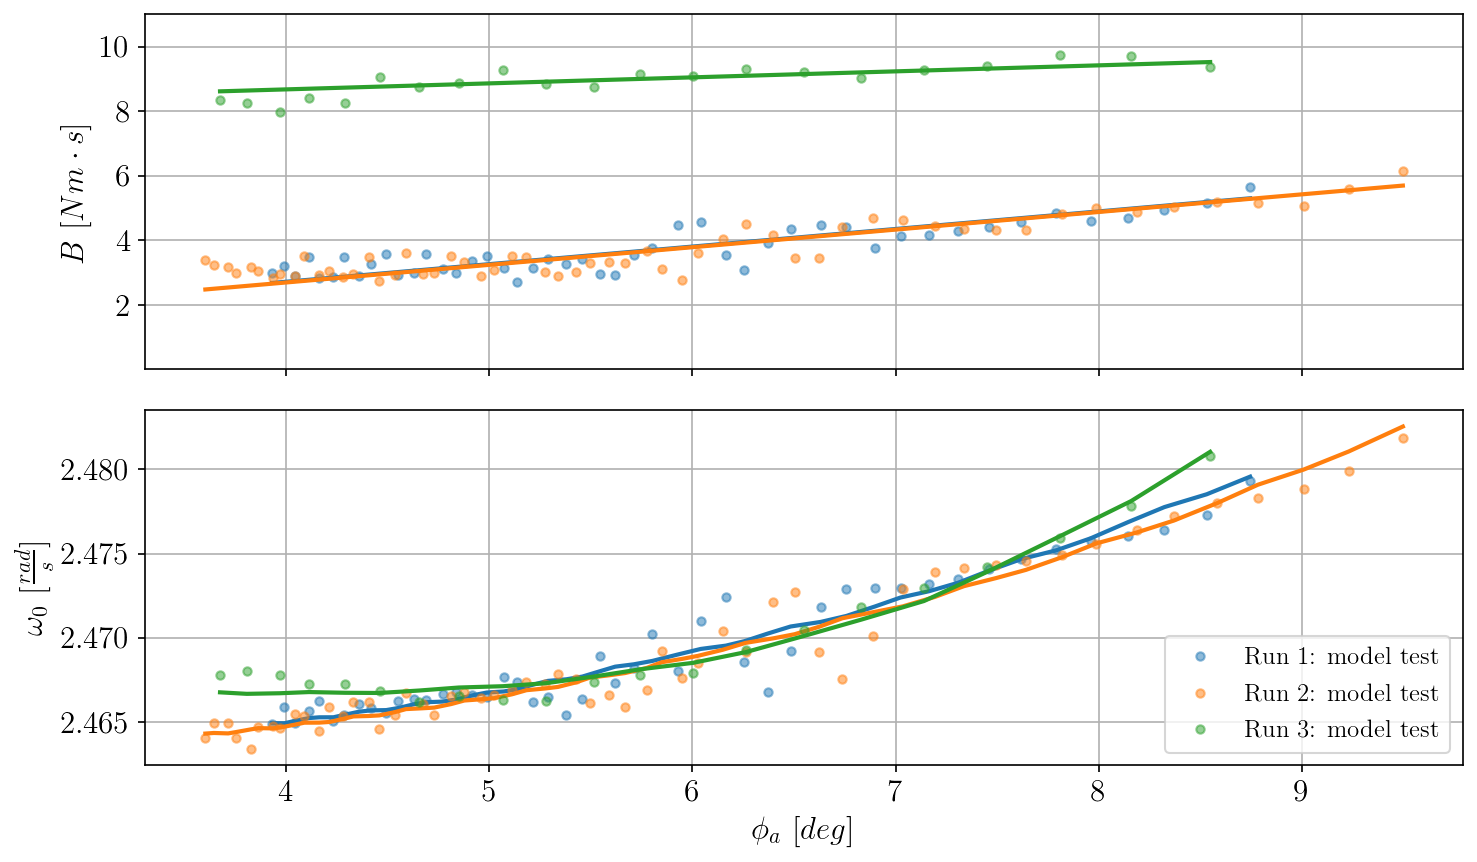

In [29]:
ylim=(0,11)
examples.mdl.show(amplitudes=amplitudes, df_results=df_results_mdl, ylim=ylim)

## Damping by Ikeda's method

Roll damping has been calculated for the validation cases with two alternative implementations of Ikeda's method. The first alternative uses the original semi-empirical formula to calculate $C_r$ coefficient for eddy damping. The second alternative uses the developed decision tree. 
These two implementations of Ikeda's method are compared with the corresponding model tests at 0 speed in Fig.[(here)](#fig_ikeda) and at speed ($F_n=0.14)$ in Fig.[(here)](#fig_ikeda_speed). The left plots in these figures show original Ikeda's method and the right plots show the decision tree alternative. The decision tree alternative shows good agreement with the model test for the 0 speed case. Ikeda's method gives much higher values for this case. For the speed case, Ikeda's method has the best agreement with model test. The decision tree alternative gives a damping that is somewhat lower than the model test.

In [30]:
models_motions, df_results_motions = reports.examples.FNPF.get_models_and_results()
amplitudes_motions = examples.FNPF.analyze_amplitudes(models=models_motions)

<a id='fig_ikeda'></a>

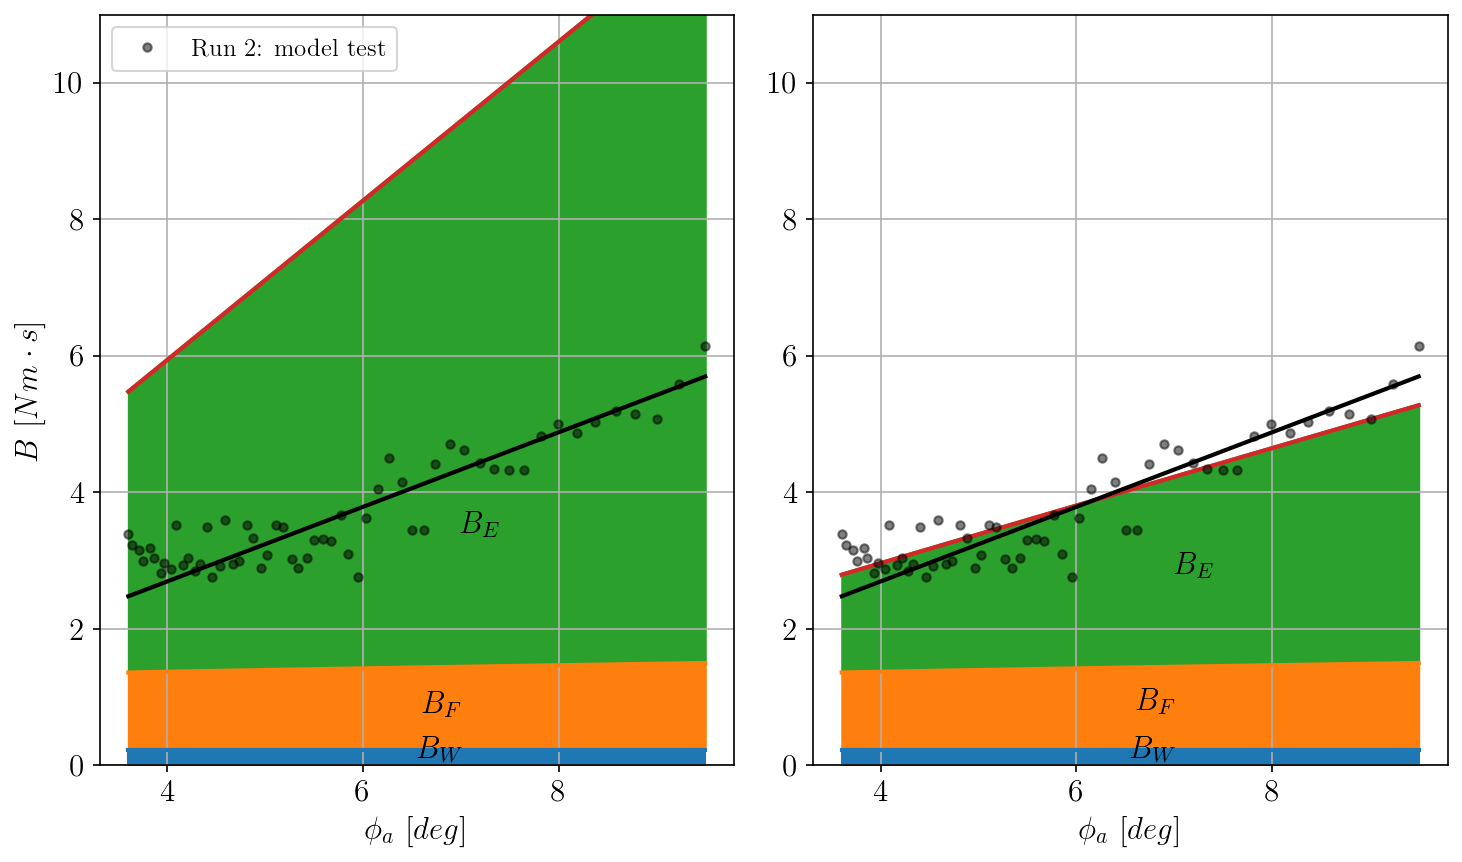

In [31]:
reports.examples.ikeda.show(amplitudes=amplitudes, amplitudes_motions=amplitudes_motions, 
                            models_mdl=models_mdl, ylim=ylim)

<a id='fig_ikeda_speed'></a>

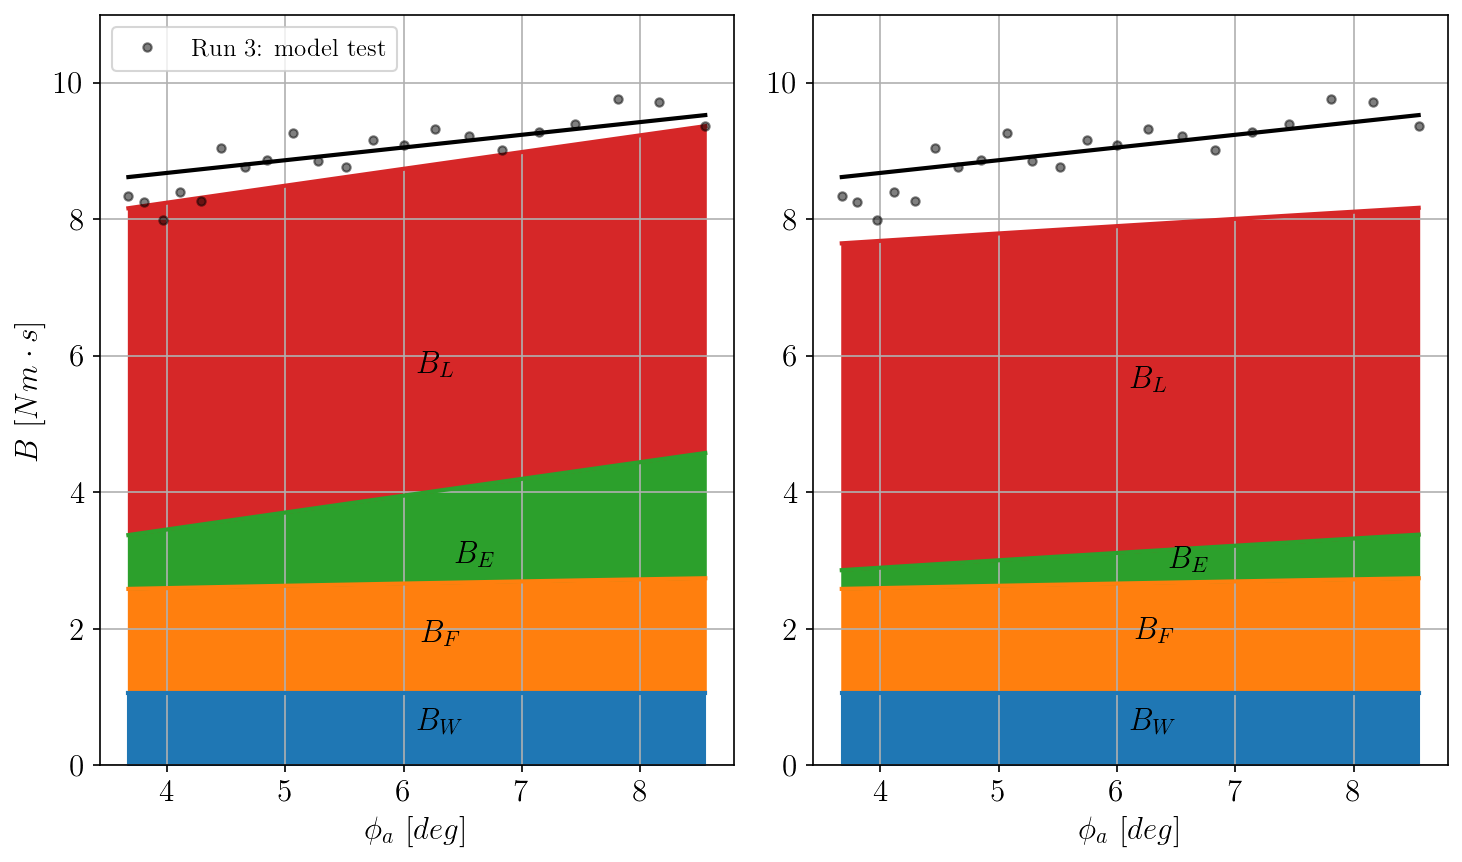

In [32]:
reports.examples.ikeda.show(amplitudes=amplitudes, amplitudes_motions=amplitudes_motions, 
                            models_mdl=models_mdl, ylim=ylim, id=21340)

The $C_r$ coefficient has been calculated for KVLCC2 with section data according to Tab.[(here)](#tab_kvlcc2_section_table). A section wise comparison between the two alternatives of Ikeda's method is shown in Fig.[(see)](#fig_kvlcc2_eddy) where the regular implementation of Ikeda's method predicts much higher $C_r$ between station 8 and 14. These stations have almost rectangular shape (see Fig.[(above)](#fig_body_plan)) with very small bilge radiuses ($R_b$). A small deviation of the sectional shape will have a large impact on the eddy damping for this kind of sections. The decision tree and Ikeda's method capture this very nonlinear behaviour differently, giving the  deviating $C_r$ predictions for stations 8 to 14.

<a id='fig_kvlcc2_eddy'></a>

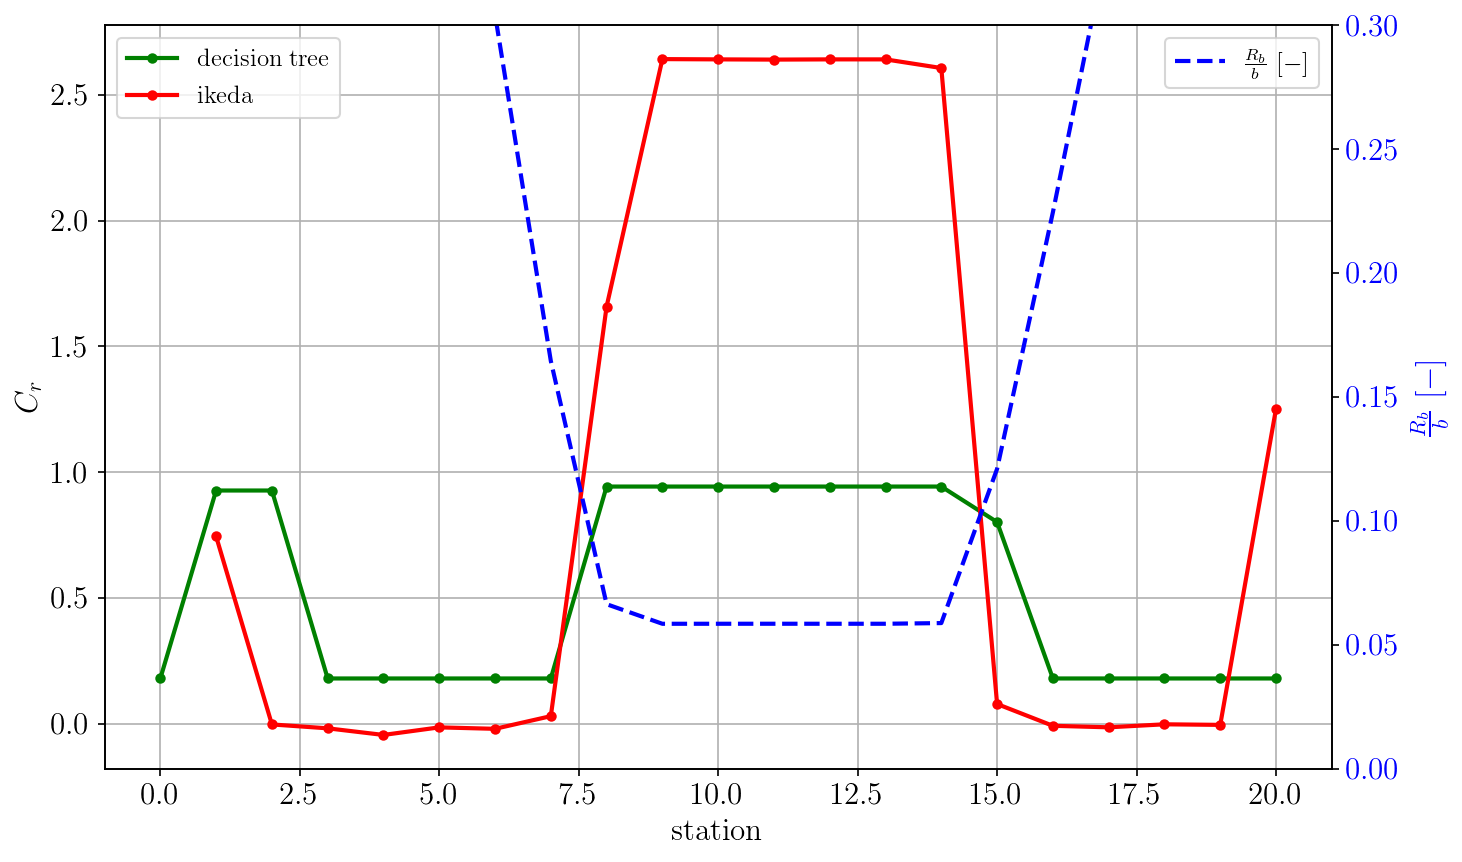

In [33]:
examples.decision_tree.show_KVLCC2_C_r_prediction()

## Motions estimated by FNPF
Simulations of roll decay tests were conducted with FNPF without viscous damping. Wave damping obtained from these tests are shown in Fig.[(below)](#fig_fnpf). FNPF predicts higher wave damping for both 0 speed and at speed, compared to Ikeda's method (see Fig.[(here)](#fig_ikeda) and Fig.[(here)](#fig_ikeda_speed)). The FNPF wave damping does not change much with the roll amplitude which  means that it is reasonably linear. This confirms the assumption used in the derivation of the eddy damping <cite data-cite="7505983/4AFVVGNT"></cite>.

<a id='fig_fnpf'></a>

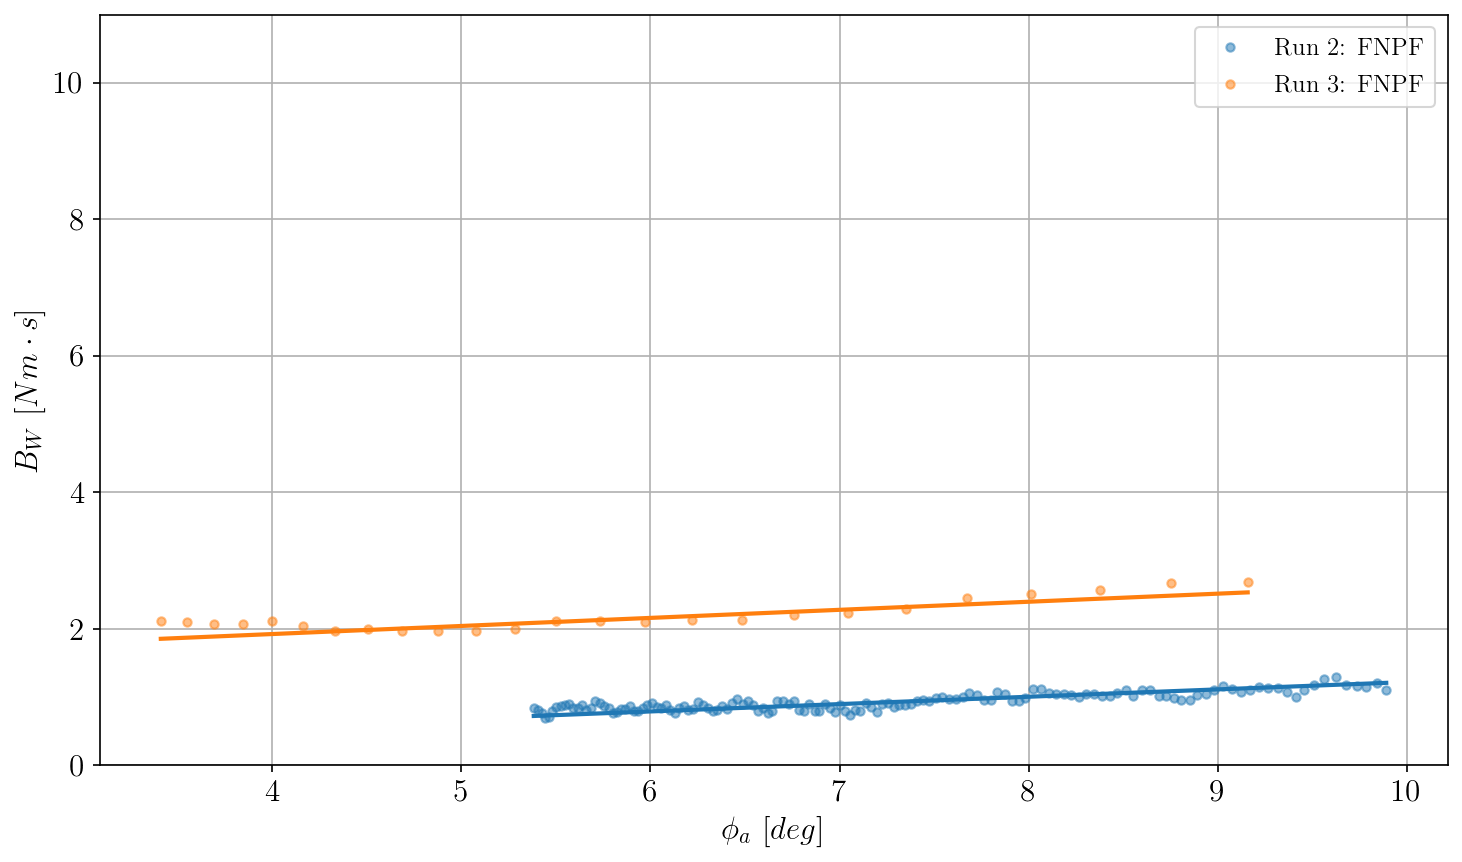

In [34]:
examples.FNPF.show(amplitudes=amplitudes_motions, df_results=df_results_motions, ylim=ylim)

## Roll motion prediction with hybrid method

The hybrid method uses the decision tree in the calculation of eddy damping and FNPF in the calculation of the wave damping. Fig.[(see)](#fig_hybrid_0) and Fig.[(see)](#fig_hybrid_speed) show comparisons between roll damping predicted with hybrid method and model tests. The hybrid method predicts higher damping than the decision tree alternative of Ikeda's method (see right plots in Fig.[(here)](#fig_ikeda) and Fig.[(here)](#fig_ikeda_speed)) due to the higher wave damping of FNPF. The hybrid method predicts roll damping that is slightly higher than the model test for the 0 speed case and very good agreement at speed case.

In [35]:
models_hybrid_0,df_results_hybrid_0 = examples.hybrid_0.get_models_and_results()

In [36]:
df_results = df_results_mdl.append(df_results_motions)
df_results = df_results.append(df_results_hybrid_0)

<a id='fig_hybrid_0'></a>

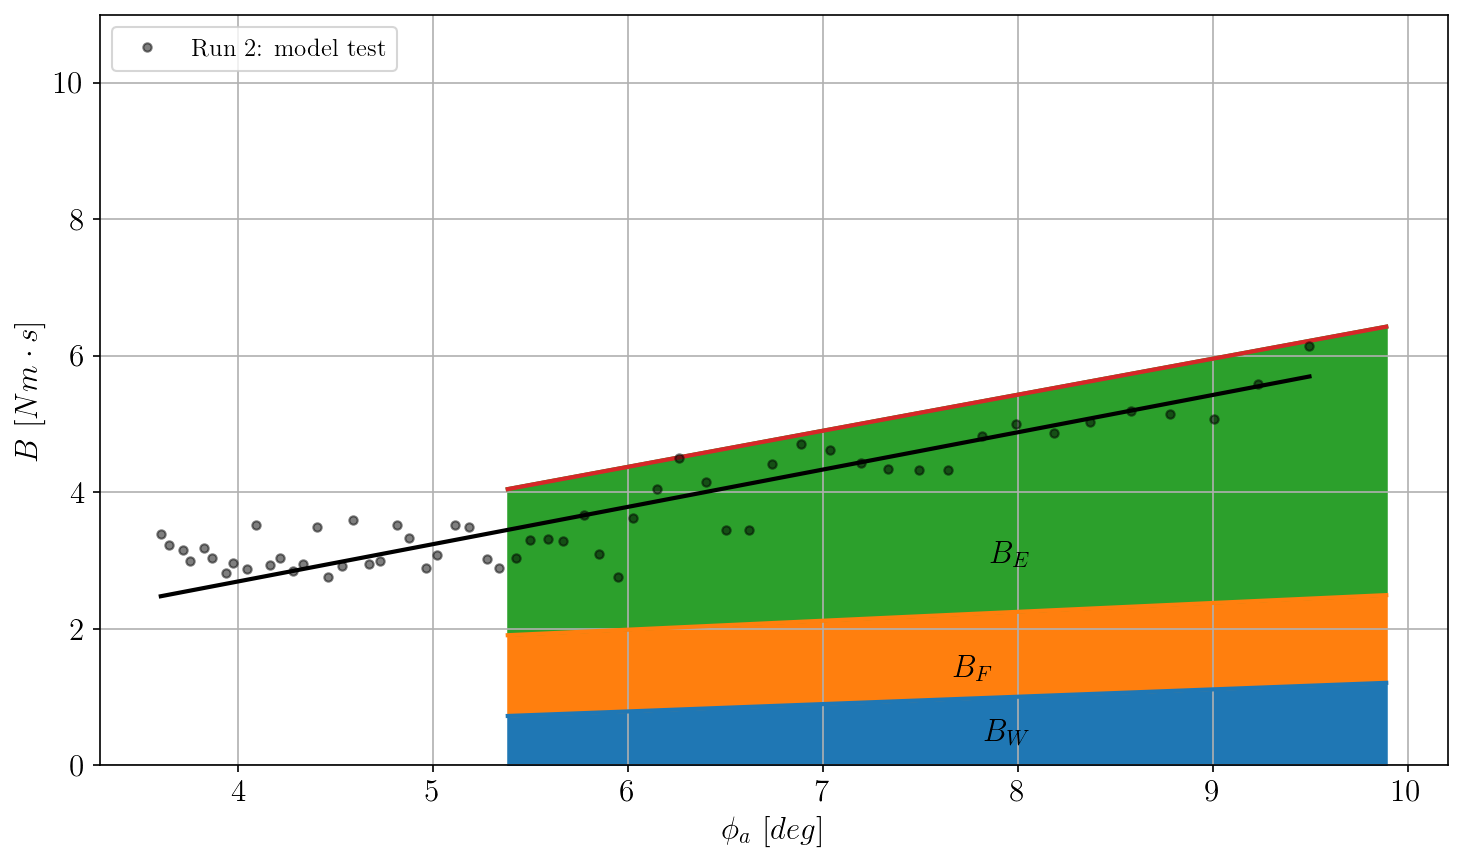

In [37]:
reports.examples.hybrid_0.show(amplitudes=amplitudes, amplitudes_motions=amplitudes_motions, 
                            models_mdl=models_mdl, ylim=ylim)




<a id='fig_hybrid_speed'></a>

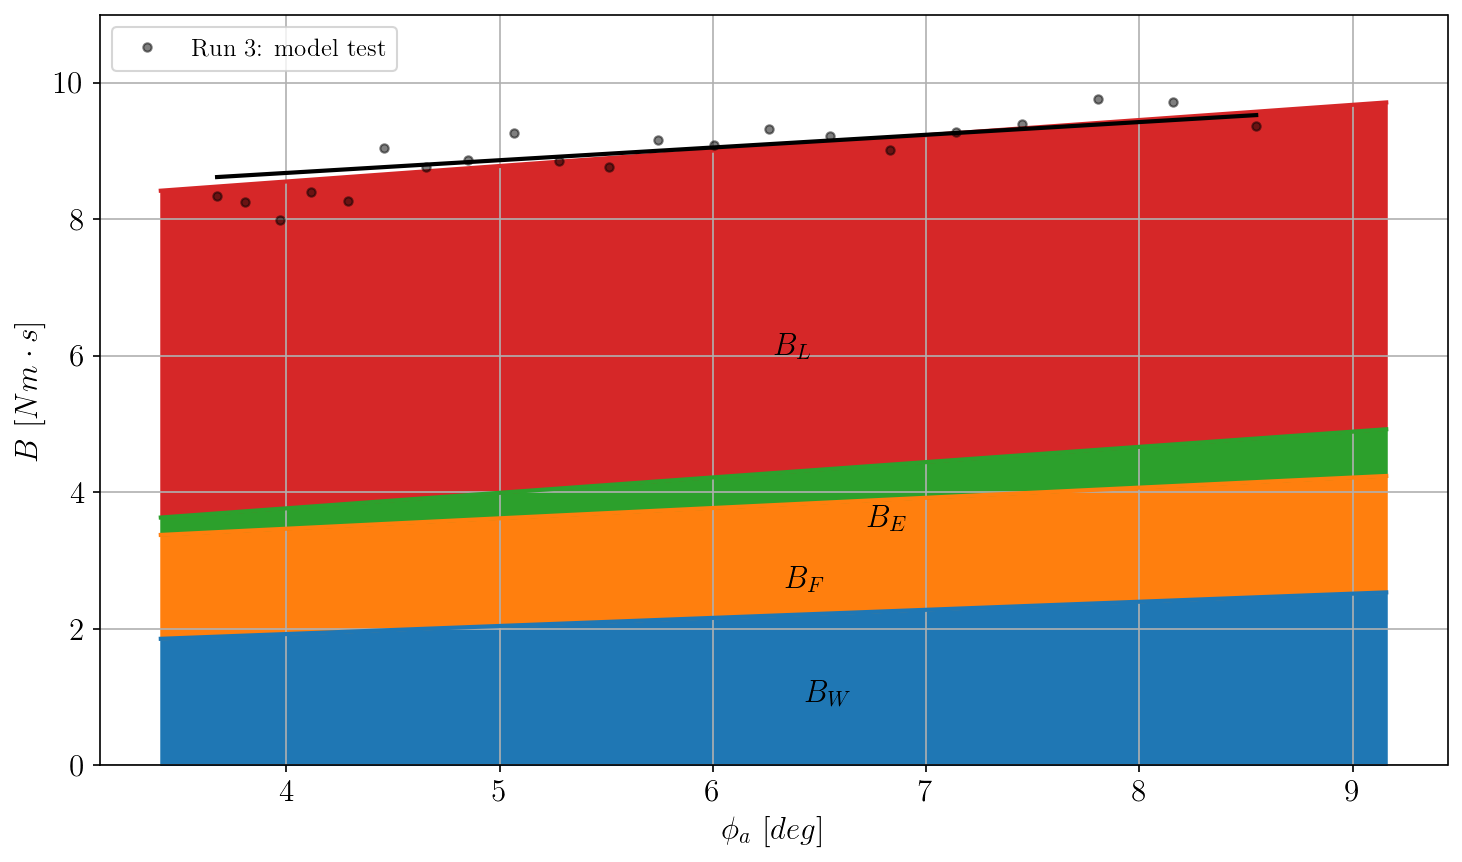

In [38]:
reports.examples.hybrid_speed.show(amplitudes=amplitudes, amplitudes_motions=amplitudes_motions, 
                            models_mdl=models_mdl, ylim=ylim)

The hybrid method can also be compared with the model tests in the time domain. Time step simulations (see section [(here)](#se_pit)) with damping coefficients from the hybrid method can be conducted to obtain these predictions. Fig.[(see)](#fig_hybrid_0_time) shows a comparison at 0 speed and Fig.[(see)](#fig_hybrid_speed_time) shows a comparison at speed. The time series from the corresponding FNPF simulations has also been added to these plots to show how much the injection of semi-empirical viscous damping can improve the accuracy of these simulations. 

<a id='fig_hybrid_0_time'></a>

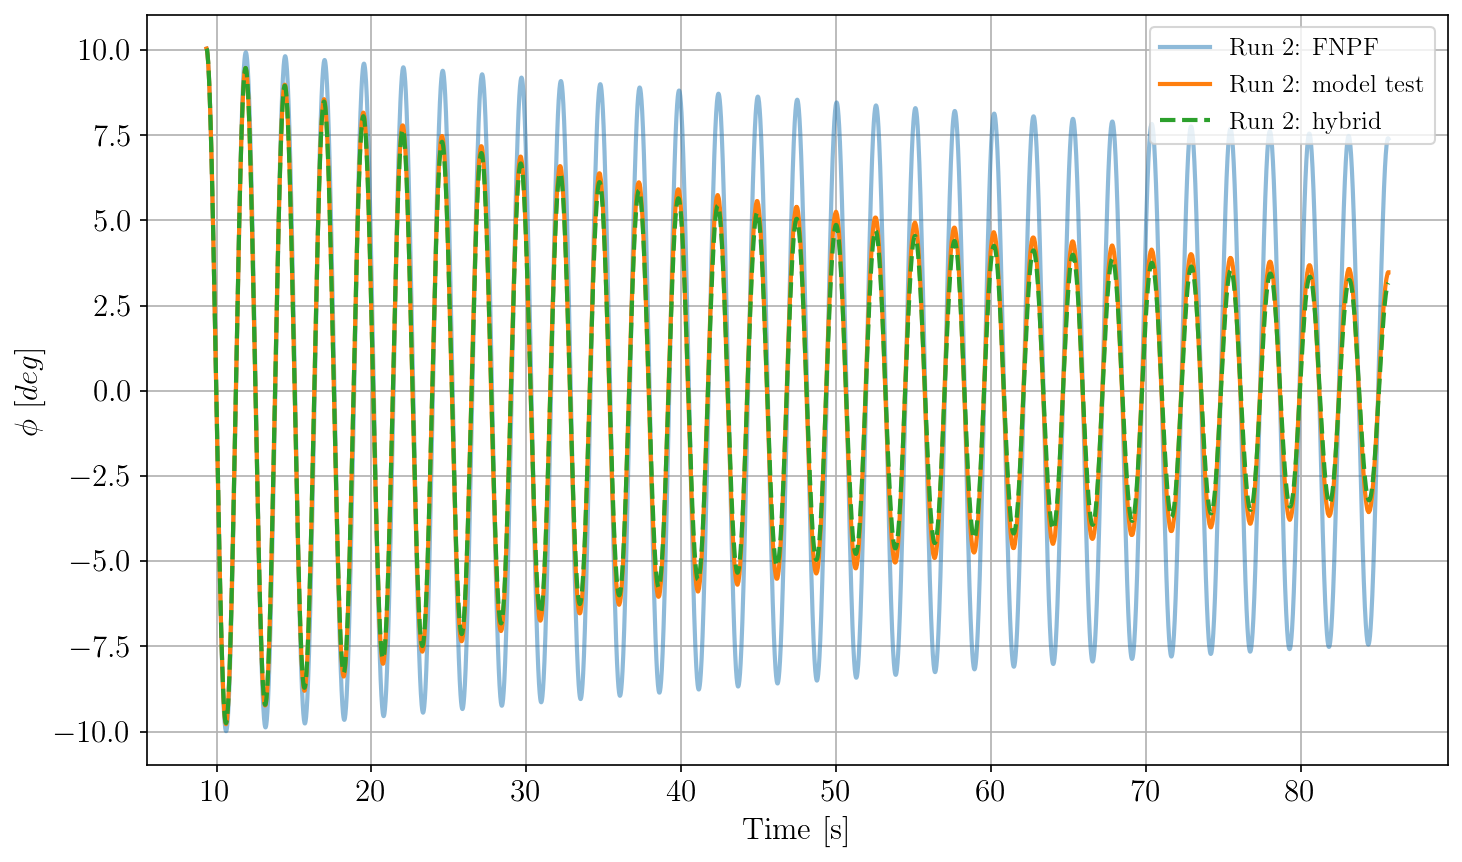

In [39]:
examples.hybrid_0.show_time(models_mdl=models_mdl, models_motions=models_motions)

<a id='fig_hybrid_speed_time'></a>

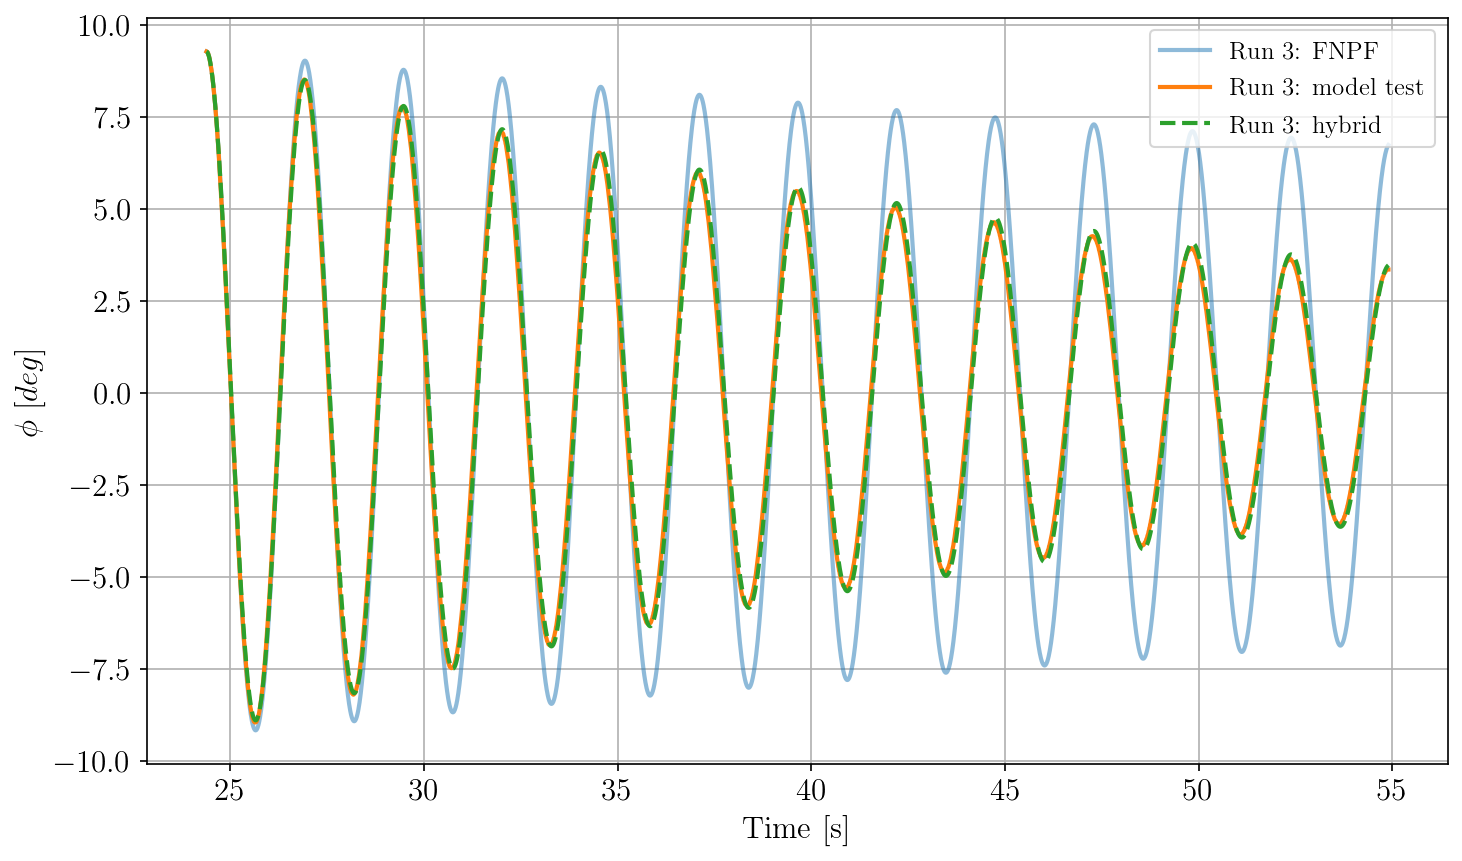

In [40]:
reports.examples.hybrid_speed.show_time(models_mdl=models_mdl, models_motions=models_motions)

The roll damping and simulated motions from the hybrid method is similar to the corresponding model test results for the zero speed case. For the in speed case the agreement is however even better as seen in the figures below.

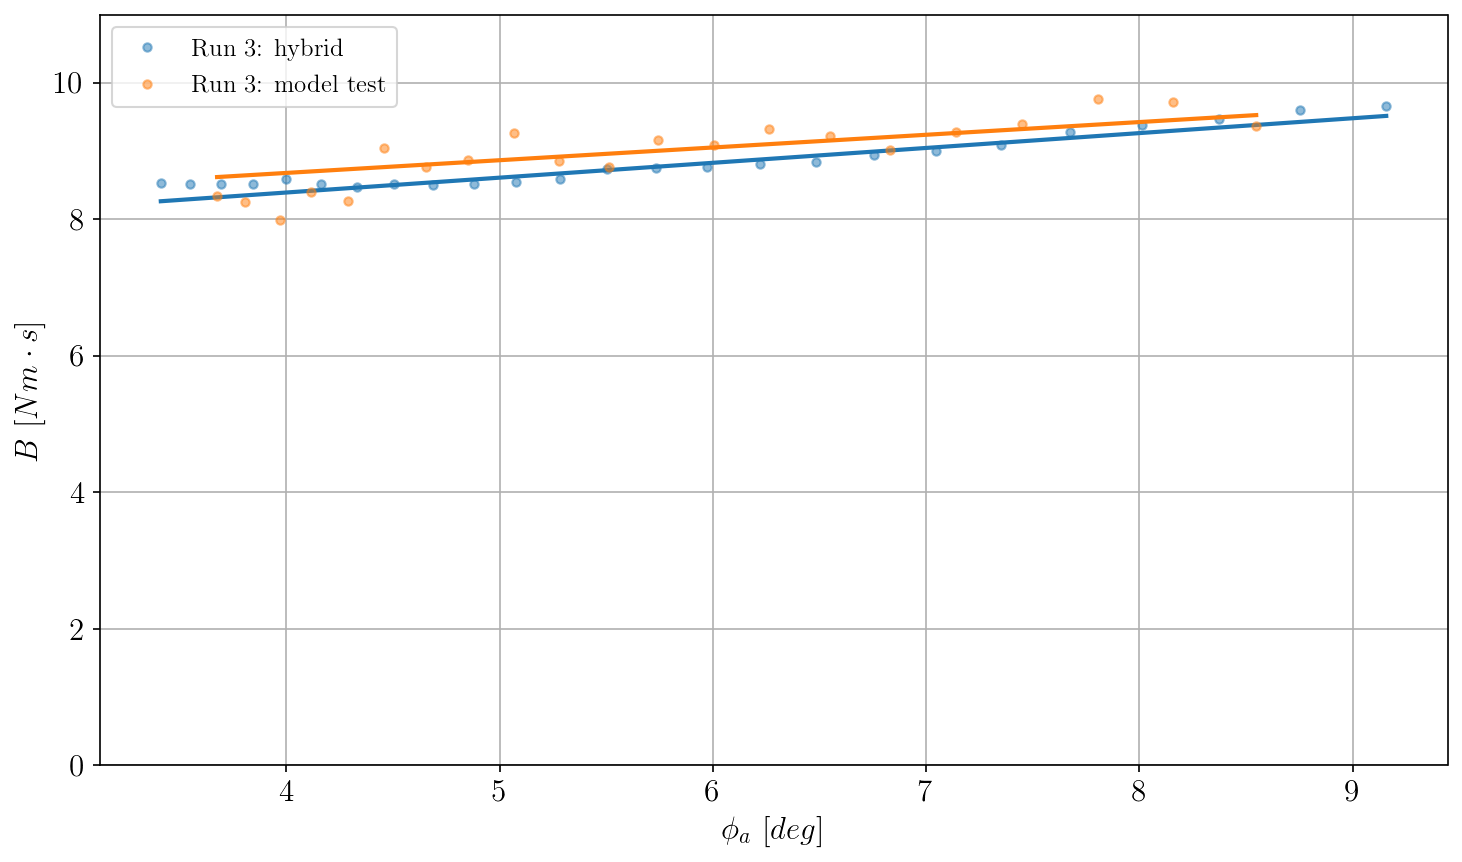

In [41]:
reports.examples.hybrid_speed.show_frequency(df_results=df_results, amplitudes=amplitudes, 
                                   amplitudes_motions=amplitudes_motions, 
                                   ylim=ylim)

The coefficients obtained from model tests, FNPF and hybrid method are summarized in model scale units in the table below. The equivalent linearized damping for 5 degrees roll angle amplitude $B_{e5}$ has also been added to this table. It can be seen that the hybrid method overpredicts the damping at 0 knots for this amplitude.

In [42]:
df_table = pd.merge(left=df_results, right=mdl_results.df_rolldecays, how='inner', 
         left_on='id', right_index=True, suffixes=('','_db'))

df_table['V'] = df_table['ship_speed']*1.852/3.6
df_table['fn'] = df_table['V']/np.sqrt(df_table['g']*df_table['lpp'])
df_table['B_e_5'] = lambdas.B_e_lambda_cubic(B_1 = df_table['B_1'],
                                             B_2 = df_table['B_2'],
                                             B_3 = 0,
                                             omega0 = df_table['omega0'],
                                             phi_a = np.deg2rad(5)
                                            )


interesting = ['fn','paper_name','method','B_1','B_2','B_e_5']

df_table_present = df_table[interesting].copy()
mask = df_table_present['method']!='FNPF'
df_table_present = df_table_present.loc[mask].copy()

rename = {
    'paper_name' : 'run',
    'fn' : r'$F_n$',
    'omega0' : r'$\omega_0$',
    'B_1' : r'$B_1$',
    'B_2' : r'$B_2$',
    'B_3' : r'$B_3$',
    'B_e_5' : r'$B_{e5}$',
}

units = {
    'fn' : r'$[-]$',
    'omega0' : r'$\left[\frac{rad}{s}\right]$',
    'B_1' : r'$[Nm \cdot s]$',
    'B_2' : r'$[Nm \cdot s^2]$',
    'B_3' : r'$[Nm \cdot s^3]$',
    'B_e_5' : r'$[Nm \cdot s]$',
}

LateXTable(df_table_present.round(decimals=2), units=units, rename=rename, 
           caption='Roll damping coefficients for model scale KVLCC2', 
           label='results')

[Index(['$F_n$', 'run', 'method', '$B_1$', '$B_2$', '$B_{e5}$'], dtype='object'),
 array(['$[-]$', '', '', '$[Nm \\cdot s]$', '$[Nm \\cdot s^2]$',
        '$[Nm \\cdot s]$'], dtype=object),
 array([0.0, 1, 'model test', 0.54, 14.95, 3.26], dtype=object),
 array([0.0, 2, 'model test', 0.51, 14.98, 3.24], dtype=object),
 array([0.0, 2, 'hybrid', 1.2, 14.5, 3.84], dtype=object),
 array([0.14, 3, 'model test', 7.93, 5.1, 8.87], dtype=object),
 array([0.14, 3, 'hybrid', 7.52, 6.01, 8.61], dtype=object)]

# Conclusions
A hybrid method to predict ship roll motions has been proposed. The method combines an existing Fully Nonlinear Potential Flow Method (FNPF) with the viscous damping contributions from Ikeda's method. Simulations of roll decay test were in very good agreement with corresponding scale model tests. The method can be used to get more accurate roll motions in potential flow simulations. This is important when roll motions are of primary interest, but can also influence other motions through coupling effects or the fact that the radiated waves from the roll motions are otherwise exaggerated. The separation of viscous and invicid roll damping in Ikeda's method seem to give very good results together with the FNPF method for the KVLCC2 test case.

A new regression formula to calculate the sectional eddy damping was also proposed in this paper. The regression formula reproduced the results from Ikeda's experiments and gave much better results with the hybrid method for KVLCC2 roll decay simulations in the present study.  

# Acknowledgements
The authors would like to acknowledge Trafikverket (Swedish Transport Administration) and Lighthouse, swedish maritime competence centre (www.lighthouse.nu) for providing the resources to prepare this paper and also thank all personnel at SSPA that have been involved in the creation of the model test results: building the ship models and conducting the experiments.

# References
<div class="cite2c-biblio"></div>

# Appendix

## Lewis sections

The Lewis section coefficients were calculated as:

In [43]:
Equation(equations_ikeda_naked.eq_D_1, label='eq:D_1', max_length=300)

<src.notebook_to_latex.Equation object>

In [44]:
Equation(equations_ikeda_naked.eq_a_3, label='eq:a_3')

<src.notebook_to_latex.Equation object>

In [45]:
Equation(equations_ikeda_naked.eq_a_1, label='eq:a_1')

<src.notebook_to_latex.Equation object>

## KVLCC2
<a id='tab_kvlcc2_section_table'></a>
The section table for KVLCC2 is shown in Tab.[(see)](#tab_kvlcc2_section_table), where the lewis section coefficients have been calculated using the equations above.

<a id='tab_kvlcc2_section_table'></a>

In [46]:
examples.KVLCC2_section_table.show()

[Index(['$x$', '$beam$', '$T_s$', '$\sigma$', '$\frac{OG}{d}$', '$R_b$',
        '$a_1$', '$a_3$'],
       dtype='object'),
 array(['$[m]$', '$[m]$', '$[m]$', '$[-]$', '$[-]', '$[m]$', '$[-]$',
        '$[-]$'], dtype=object),
 array([-0.0808, 0.1712, 0.0294, 0.594, 1.1, 0.0976, 0.5341, 0.0935],
       dtype=object),
 array([0.1494, 0.4102, 0.2684, 0.2433, 0.1205, 0.623, -0.1824, 0.3651],
       dtype=object),
 array([0.4125, 0.6151, 0.3059, 0.4922, 0.1058, 0.6672, 0.0032, 0.1916],
       dtype=object),
 array([0.6427, 0.7394, 0.3059, 0.6537, 0.1058, 0.6041, 0.1024, 0.0836],
       dtype=object),
 array([0.9058, 0.8259, 0.3059, 0.7858, 0.1058, 0.5021, 0.1489, -0.0002],
       dtype=object),
 array([1.1361, 0.851, 0.3059, 0.878, 0.1058, 0.3847, 0.1542, -0.0576],
       dtype=object),
 array([1.3663, 0.8529, 0.3059, 0.9445, 0.1058, 0.2596, 0.1482, -0.0998],
       dtype=object),
 array([1.6294, 0.8529, 0.3059, 0.9838, 0.1058, 0.1404, 0.144, -0.1255],
       dtype=object),
 array([1.8596, 0.8529, 0.3059, 0.9974, 0.1058, 0.0566, 0.1425, -0.1345],
       dtype=object),
 array([2.1227, 0.8529, 0.3059, 0.998, 0.1058, 0.0499, 0.1424, -0.1349],
       dtype=object),
 array([2.3529, 0.8529, 0.3059, 0.998, 0.1058, 0.0499, 0.1424, -0.1349],
       dtype=object),
 array([2.5866, 0.8529, 0.3059, 0.998, 0.1058, 0.0499, 0.1424, -0.1349],
       dtype=object),
 array([2.8537, 0.8529, 0.3059, 0.998, 0.1058, 0.0499, 0.1424, -0.1349],
       dtype=object),
 array([3.0874, 0.8529, 0.3059, 0.998, 0.1058, 0.0499, 0.1424, -0.1349],
       dtype=object),
 array([3.3211, 0.8529, 0.3059, 0.9979, 0.1058, 0.0501, 0.1424, -0.1349],
       dtype=object),
 array([3.5882, 0.8528, 0.3059, 0.9912, 0.1058, 0.1032, 0.1431, -0.1304],
       dtype=object),
 array([3.8219, 0.8454, 0.3059, 0.9701, 0.1058, 0.1898, 0.1416, -0.1166],
       dtype=object),
 array([4.0556, 0.8141, 0.3059, 0.9358, 0.1058, 0.273, 0.1285, -0.0949],
       dtype=object),
 array([4.2893, 0.7078, 0.3059, 0.8981, 0.1058, 0.3206, 0.0676, -0.0718],
       dtype=object),
 array([4.5564, 0.4148, 0.3059, 0.8566, 0.1058, 0.2911, -0.1835, -0.0438],
       dtype=object),
 array([4.7901, 0.084, 0.2379, 0.4708, 0.136, 0.222, -0.7722, 0.103],
       dtype=object)]

# Nomenclature

In [47]:
## Additional symbols (not in eq. but should be in nomenclature):
Equation(symbols.Fn,label='Fn')
Equation(symbols.T,label='T')
Equation(symbols.K_xx,label='kxx')
Equation(symbols.S,label='S')
Equation(symbols.Disp,label='Disp')
Equation(symbols.rho,label='rho')
Equation(symbols.kg,label='kg')
Equation(symbols.r2,label='r2')

<src.notebook_to_latex.Equation object>

In [48]:
from reports.paper_writing import _get_symbols,_generate_latex_nomenclature
symbols_nomenclature = _get_symbols(equation_dict=equation_dict)

removes = [
'AP',
'FP',
"B'_E0",
"B_1","B_2","C_1","C_3","C_5",
'K',
'B_E0',
'B_E',
#'omega',
#'L_pp',
#'V',
#'T_s',
'phi_a',
'rho',
'C_r',
#'sigma',
#'B_s',
'R_b',
'B_E0_HAT',
'B_E_star_hat',
'B_W_star_hat',
'B_star_hat',
'B_F_star_hat',
#'g',
#'b',
#'t', 
'A_44',
'C_1A',
'B_1A',
'C_5A',
'C_3A',
'B_2A',
'zeta',
#'omega0',
'B_e',
'D_1',
'H_0',
#'a_3',
#'a_1',
#'F_n',
#'T',
#'K_xx',
#'S',
#'Disp',
#'kg']
]

for remove in removes:
    symbols_nomenclature.pop(remove)


text = '\\vspace{-1.3cm}\n'

additional_descriptions = {
    equations.new_symbols[symbols.B_1] : 'Damping helpers',
    equations.new_symbols[symbols.B_2] : 'Damping helpers',
    equations.new_symbols[symbols.B_3] : 'Damping helpers',
    equations.new_symbols[symbols.C_1] : 'Stiffness helpers',
    equations.new_symbols[symbols.C_3] : 'Stiffness helpers',
    equations.new_symbols[symbols.C_5] : 'Stiffness helpers',
    symbols.B_1 : 'Linear damping coefficient',
    symbols.B_2 : 'Quadratic damping coefficient',
    symbols.B_3 : 'Cubic damping coefficient',
    symbols.C_1 : 'Stiffness coefficient',
    symbols.C_3 : 'Stiffness coefficient',
    symbols.C_5 : 'Stiffness coefficient',
}

additions_units = {
    symbols.B_1 : 'Nm*s',
    symbols.B_2 : 'Nm*s**2',
    symbols.B_3 : 'Nm*s**3',
    symbols.C_1 : 'Nm',
    symbols.C_3 : 'Nm',
    symbols.C_5 : 'Nm',

}

latex_nomenclature = text + _generate_latex_nomenclature(symbols=symbols_nomenclature, 
                                                        additional_descriptions=additional_descriptions,
                                                        additions_units=additions_units)
display(Latex(latex_nomenclature))

KeyError: 'AP'